In [6]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform, truncnorm, randint

from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_curve, auc, precision_score, confusion_matrix,\
 ConfusionMatrixDisplay, recall_score, accuracy_score, f1_score, classification_report, make_scorer
import pickle
import matplotlib.pyplot as plt

In [2]:
# Preprocess data
def process_data(name):
    file = r'../data/' + name + '.csv'
    print("processing file: {}".format(file))
    file = pd.read_csv(r'../data/cases_train_preprocessed.csv',dtype=object)
    file.drop(columns=['land','Last_Update','province','country'],inplace=True)
    file['source'] = file['source'].fillna(value='')
    return file
file = process_data("cases_train_preprocessed")

processing file: ../data/cases_train_preprocessed.csv


In [3]:
# Train / Test split for model evaluation
def catboost_data(file):
    cat_feature=['sex','source','age_range_ind','age_range']
    text_feature = ['additional_information']

    df_tr, df_va = train_test_split(file, test_size=0.2, random_state = 1)

    df_tr_x = df_tr.drop(columns="outcome")
    df_tr_y = df_tr['outcome']

    df_tr_data = Pool(data = df_tr_x,
                   label = df_tr_y,
                   cat_features = cat_feature, 
                   text_features=text_feature)

    df_va_x = df_va.drop(columns="outcome")
    df_va_y = df_va['outcome']

    df_va_data = Pool(data = df_va_x,
                   label = df_va_y,
                   cat_features = cat_feature, 
                   text_features=text_feature)
    return df_tr_x, df_tr_y, df_va_x, df_va_y
tr, tr_y, va, va_y = catboost_data(file)

In [10]:
# Specifying possible parameters of catboost - Random Search 
grid = {'learning_rate': uniform(0.2, 0.4),
        'depth': randint(10,14),
        'l2_leaf_reg': uniform(0.0, 0.2),
        'n_estimators':randint(100, 400)
       }

# Specify catboost parameters
cat_feature=['sex','source','age_range_ind','age_range']
text_feature = ['additional_information']

# Creating required scoring function
scorer = {
    'f1_macro' : make_scorer(f1_score, average='macro'),
    'recall_macro': make_scorer(recall_score , average='macro'),
    'accuracy': make_scorer(accuracy_score),
    'recall_d' : make_scorer(recall_score,average=None,labels=['deceased']),
    'f1_d' : make_scorer(f1_score, average=None, labels=['deceased']),
}

# Creating Catboost model
model = CatBoostClassifier( task_type="GPU",
                            devices='0:1',
                            loss_function='MultiClass',
                            auto_class_weights = 'SqrtBalanced',
                            cat_features = cat_feature,
                            text_features = text_feature)

clf_rand = RandomizedSearchCV(estimator=model, param_distributions=grid, scoring=scorer, cv= 5, refit="f1_d", n_jobs=1, verbose=1)
model = clf_rand.fit(tr, tr_y)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 1.0862445	total: 125ms	remaining: 21s
1:	learn: 0.8981918	total: 261ms	remaining: 21.8s
2:	learn: 0.7798132	total: 390ms	remaining: 21.6s
3:	learn: 0.6977436	total: 537ms	remaining: 22.2s
4:	learn: 0.6387477	total: 670ms	remaining: 22s
5:	learn: 0.5974823	total: 821ms	remaining: 22.3s
6:	learn: 0.5637592	total: 958ms	remaining: 22.2s
7:	learn: 0.5370139	total: 1.1s	remaining: 22.2s
8:	learn: 0.5180528	total: 1.24s	remaining: 22s
9:	learn: 0.5013725	total: 1.37s	remaining: 21.7s
10:	learn: 0.4882885	total: 1.5s	remaining: 21.6s
11:	learn: 0.4770519	total: 1.64s	remaining: 21.5s
12:	learn: 0.4689101	total: 1.78s	remaining: 21.4s
13:	learn: 0.4607965	total: 1.91s	remaining: 21.1s
14:	learn: 0.4544120	total: 2.04s	remaining: 20.9s
15:	learn: 0.4505117	total: 2.16s	remaining: 20.6s
16:	learn: 0.4452559	total: 2.29s	remaining: 20.5s
17:	learn: 0.4414867	total: 2.45s	remaining: 20.5s
18:	learn: 0.4393845	total: 2.57s	remai

160:	learn: 0.3084038	total: 22.4s	remaining: 1.11s
161:	learn: 0.3082149	total: 22.5s	remaining: 974ms
162:	learn: 0.3075816	total: 22.7s	remaining: 835ms
163:	learn: 0.3074072	total: 22.8s	remaining: 695ms
164:	learn: 0.3071216	total: 22.9s	remaining: 556ms
165:	learn: 0.3067584	total: 23.1s	remaining: 417ms
166:	learn: 0.3064229	total: 23.2s	remaining: 278ms
167:	learn: 0.3058831	total: 23.4s	remaining: 139ms
168:	learn: 0.3050607	total: 23.5s	remaining: 0us
0:	learn: 1.0861545	total: 138ms	remaining: 23.2s
1:	learn: 0.8995175	total: 283ms	remaining: 23.6s
2:	learn: 0.7809338	total: 416ms	remaining: 23s
3:	learn: 0.6981485	total: 561ms	remaining: 23.1s
4:	learn: 0.6407577	total: 697ms	remaining: 22.9s
5:	learn: 0.5973681	total: 852ms	remaining: 23.1s
6:	learn: 0.5641867	total: 999ms	remaining: 23.1s
7:	learn: 0.5403258	total: 1.14s	remaining: 23s
8:	learn: 0.5214620	total: 1.28s	remaining: 22.9s
9:	learn: 0.5045912	total: 1.42s	remaining: 22.5s
10:	learn: 0.4885216	total: 1.56s	rema

152:	learn: 0.3166656	total: 21.1s	remaining: 2.21s
153:	learn: 0.3163650	total: 21.3s	remaining: 2.07s
154:	learn: 0.3155622	total: 21.4s	remaining: 1.93s
155:	learn: 0.3149502	total: 21.6s	remaining: 1.8s
156:	learn: 0.3148008	total: 21.7s	remaining: 1.66s
157:	learn: 0.3143106	total: 21.9s	remaining: 1.52s
158:	learn: 0.3136066	total: 22s	remaining: 1.38s
159:	learn: 0.3131111	total: 22.2s	remaining: 1.25s
160:	learn: 0.3127854	total: 22.3s	remaining: 1.11s
161:	learn: 0.3123456	total: 22.4s	remaining: 970ms
162:	learn: 0.3117440	total: 22.6s	remaining: 831ms
163:	learn: 0.3116191	total: 22.7s	remaining: 692ms
164:	learn: 0.3112872	total: 22.8s	remaining: 554ms
165:	learn: 0.3111659	total: 23s	remaining: 415ms
166:	learn: 0.3111263	total: 23.1s	remaining: 277ms
167:	learn: 0.3104257	total: 23.3s	remaining: 138ms
168:	learn: 0.3095910	total: 23.4s	remaining: 0us
0:	learn: 1.0872866	total: 140ms	remaining: 23.5s
1:	learn: 0.8979120	total: 283ms	remaining: 23.6s
2:	learn: 0.7772943	tot

144:	learn: 0.3210378	total: 20.1s	remaining: 3.33s
145:	learn: 0.3206896	total: 20.3s	remaining: 3.19s
146:	learn: 0.3202464	total: 20.4s	remaining: 3.05s
147:	learn: 0.3198770	total: 20.5s	remaining: 2.92s
148:	learn: 0.3192171	total: 20.7s	remaining: 2.78s
149:	learn: 0.3191584	total: 20.8s	remaining: 2.64s
150:	learn: 0.3183579	total: 21s	remaining: 2.5s
151:	learn: 0.3176477	total: 21.2s	remaining: 2.37s
152:	learn: 0.3172257	total: 21.3s	remaining: 2.23s
153:	learn: 0.3166999	total: 21.4s	remaining: 2.09s
154:	learn: 0.3163560	total: 21.6s	remaining: 1.95s
155:	learn: 0.3160969	total: 21.7s	remaining: 1.81s
156:	learn: 0.3157087	total: 21.8s	remaining: 1.67s
157:	learn: 0.3152599	total: 22s	remaining: 1.53s
158:	learn: 0.3150174	total: 22.1s	remaining: 1.39s
159:	learn: 0.3146066	total: 22.3s	remaining: 1.25s
160:	learn: 0.3138700	total: 22.4s	remaining: 1.11s
161:	learn: 0.3131750	total: 22.6s	remaining: 977ms
162:	learn: 0.3128106	total: 22.8s	remaining: 838ms
163:	learn: 0.312

136:	learn: 0.3303547	total: 18.6s	remaining: 4.35s
137:	learn: 0.3301276	total: 18.7s	remaining: 4.21s
138:	learn: 0.3293271	total: 18.9s	remaining: 4.08s
139:	learn: 0.3288532	total: 19s	remaining: 3.94s
140:	learn: 0.3284953	total: 19.2s	remaining: 3.81s
141:	learn: 0.3283169	total: 19.3s	remaining: 3.67s
142:	learn: 0.3278464	total: 19.4s	remaining: 3.54s
143:	learn: 0.3274117	total: 19.6s	remaining: 3.4s
144:	learn: 0.3267808	total: 19.7s	remaining: 3.26s
145:	learn: 0.3260956	total: 19.9s	remaining: 3.13s
146:	learn: 0.3252777	total: 20s	remaining: 3s
147:	learn: 0.3248199	total: 20.2s	remaining: 2.86s
148:	learn: 0.3242907	total: 20.3s	remaining: 2.73s
149:	learn: 0.3238341	total: 20.4s	remaining: 2.59s
150:	learn: 0.3226002	total: 20.6s	remaining: 2.46s
151:	learn: 0.3225341	total: 20.7s	remaining: 2.32s
152:	learn: 0.3220557	total: 20.9s	remaining: 2.18s
153:	learn: 0.3214869	total: 21s	remaining: 2.05s
154:	learn: 0.3211331	total: 21.1s	remaining: 1.91s
155:	learn: 0.3206862	

128:	learn: 0.3297772	total: 17.5s	remaining: 5.43s
129:	learn: 0.3293443	total: 17.7s	remaining: 5.3s
130:	learn: 0.3293066	total: 17.8s	remaining: 5.16s
131:	learn: 0.3288160	total: 17.9s	remaining: 5.02s
132:	learn: 0.3280673	total: 18.1s	remaining: 4.89s
133:	learn: 0.3280098	total: 18.2s	remaining: 4.75s
134:	learn: 0.3273619	total: 18.3s	remaining: 4.62s
135:	learn: 0.3271862	total: 18.5s	remaining: 4.48s
136:	learn: 0.3266643	total: 18.6s	remaining: 4.35s
137:	learn: 0.3255625	total: 18.8s	remaining: 4.22s
138:	learn: 0.3250018	total: 18.9s	remaining: 4.09s
139:	learn: 0.3245435	total: 19.1s	remaining: 3.95s
140:	learn: 0.3237307	total: 19.2s	remaining: 3.82s
141:	learn: 0.3227767	total: 19.4s	remaining: 3.69s
142:	learn: 0.3221274	total: 19.6s	remaining: 3.56s
143:	learn: 0.3218730	total: 19.7s	remaining: 3.42s
144:	learn: 0.3213902	total: 19.9s	remaining: 3.29s
145:	learn: 0.3205522	total: 20s	remaining: 3.15s
146:	learn: 0.3202335	total: 20.1s	remaining: 3.01s
147:	learn: 0.3

120:	learn: 0.2772250	total: 17.3s	remaining: 2.57s
121:	learn: 0.2771294	total: 17.4s	remaining: 2.42s
122:	learn: 0.2758067	total: 17.6s	remaining: 2.28s
123:	learn: 0.2754614	total: 17.7s	remaining: 2.14s
124:	learn: 0.2747591	total: 17.8s	remaining: 2s
125:	learn: 0.2736764	total: 18s	remaining: 1.86s
126:	learn: 0.2734682	total: 18.1s	remaining: 1.71s
127:	learn: 0.2726913	total: 18.3s	remaining: 1.57s
128:	learn: 0.2720039	total: 18.4s	remaining: 1.43s
129:	learn: 0.2713413	total: 18.6s	remaining: 1.29s
130:	learn: 0.2708310	total: 18.7s	remaining: 1.14s
131:	learn: 0.2701558	total: 18.9s	remaining: 1s
132:	learn: 0.2698415	total: 19s	remaining: 857ms
133:	learn: 0.2695745	total: 19.1s	remaining: 714ms
134:	learn: 0.2688963	total: 19.3s	remaining: 571ms
135:	learn: 0.2683027	total: 19.4s	remaining: 428ms
136:	learn: 0.2676061	total: 19.5s	remaining: 285ms
137:	learn: 0.2662451	total: 19.7s	remaining: 143ms
138:	learn: 0.2654220	total: 19.9s	remaining: 0us
0:	learn: 0.8722131	tota

4:	learn: 0.4979796	total: 677ms	remaining: 18.1s
5:	learn: 0.4787488	total: 805ms	remaining: 17.8s
6:	learn: 0.4614933	total: 933ms	remaining: 17.6s
7:	learn: 0.4498054	total: 1.08s	remaining: 17.7s
8:	learn: 0.4438029	total: 1.21s	remaining: 17.4s
9:	learn: 0.4326988	total: 1.35s	remaining: 17.4s
10:	learn: 0.4273605	total: 1.49s	remaining: 17.3s
11:	learn: 0.4241065	total: 1.61s	remaining: 17s
12:	learn: 0.4191944	total: 1.74s	remaining: 16.8s
13:	learn: 0.4144011	total: 1.87s	remaining: 16.7s
14:	learn: 0.4114545	total: 2.01s	remaining: 16.6s
15:	learn: 0.4083734	total: 2.14s	remaining: 16.4s
16:	learn: 0.4071160	total: 2.27s	remaining: 16.3s
17:	learn: 0.4043162	total: 2.4s	remaining: 16.1s
18:	learn: 0.3986528	total: 2.54s	remaining: 16s
19:	learn: 0.3976420	total: 2.65s	remaining: 15.8s
20:	learn: 0.3968526	total: 2.77s	remaining: 15.6s
21:	learn: 0.3957819	total: 2.89s	remaining: 15.3s
22:	learn: 0.3944030	total: 3.01s	remaining: 15.2s
23:	learn: 0.3924747	total: 3.15s	remainin

26:	learn: 0.3898925	total: 3.56s	remaining: 14.8s
27:	learn: 0.3866894	total: 3.72s	remaining: 14.7s
28:	learn: 0.3849394	total: 3.86s	remaining: 14.6s
29:	learn: 0.3835543	total: 3.99s	remaining: 14.5s
30:	learn: 0.3805425	total: 4.14s	remaining: 14.4s
31:	learn: 0.3785618	total: 4.27s	remaining: 14.3s
32:	learn: 0.3774649	total: 4.41s	remaining: 14.2s
33:	learn: 0.3754436	total: 4.54s	remaining: 14s
34:	learn: 0.3723845	total: 4.72s	remaining: 14s
35:	learn: 0.3701754	total: 4.9s	remaining: 14s
36:	learn: 0.3690641	total: 5.02s	remaining: 13.8s
37:	learn: 0.3667484	total: 5.16s	remaining: 13.7s
38:	learn: 0.3657931	total: 5.3s	remaining: 13.6s
39:	learn: 0.3645448	total: 5.45s	remaining: 13.5s
40:	learn: 0.3639345	total: 5.58s	remaining: 13.3s
41:	learn: 0.3629939	total: 5.7s	remaining: 13.2s
42:	learn: 0.3619336	total: 5.85s	remaining: 13.1s
43:	learn: 0.3607548	total: 5.99s	remaining: 12.9s
44:	learn: 0.3597806	total: 6.12s	remaining: 12.8s
45:	learn: 0.3586787	total: 6.27s	remain

50:	learn: 0.3469986	total: 7.03s	remaining: 12.1s
51:	learn: 0.3466850	total: 7.16s	remaining: 12s
52:	learn: 0.3454752	total: 7.29s	remaining: 11.8s
53:	learn: 0.3443602	total: 7.43s	remaining: 11.7s
54:	learn: 0.3423766	total: 7.6s	remaining: 11.6s
55:	learn: 0.3408497	total: 7.74s	remaining: 11.5s
56:	learn: 0.3396313	total: 7.87s	remaining: 11.3s
57:	learn: 0.3384040	total: 8s	remaining: 11.2s
58:	learn: 0.3379834	total: 8.13s	remaining: 11s
59:	learn: 0.3374714	total: 8.25s	remaining: 10.9s
60:	learn: 0.3359559	total: 8.39s	remaining: 10.7s
61:	learn: 0.3348313	total: 8.53s	remaining: 10.6s
62:	learn: 0.3330282	total: 8.7s	remaining: 10.5s
63:	learn: 0.3316759	total: 8.84s	remaining: 10.4s
64:	learn: 0.3299933	total: 8.99s	remaining: 10.2s
65:	learn: 0.3285829	total: 9.14s	remaining: 10.1s
66:	learn: 0.3274235	total: 9.28s	remaining: 9.97s
67:	learn: 0.3267112	total: 9.41s	remaining: 9.82s
68:	learn: 0.3258300	total: 9.55s	remaining: 9.69s
69:	learn: 0.3251224	total: 9.71s	remain

76:	learn: 0.3940066	total: 4.25s	remaining: 15.1s
77:	learn: 0.3937193	total: 4.3s	remaining: 15s
78:	learn: 0.3924931	total: 4.35s	remaining: 15s
79:	learn: 0.3918256	total: 4.41s	remaining: 14.9s
80:	learn: 0.3916077	total: 4.46s	remaining: 14.9s
81:	learn: 0.3903809	total: 4.52s	remaining: 14.8s
82:	learn: 0.3897531	total: 4.58s	remaining: 14.8s
83:	learn: 0.3890358	total: 4.64s	remaining: 14.7s
84:	learn: 0.3886204	total: 4.69s	remaining: 14.7s
85:	learn: 0.3882321	total: 4.74s	remaining: 14.6s
86:	learn: 0.3881955	total: 4.79s	remaining: 14.5s
87:	learn: 0.3878391	total: 4.84s	remaining: 14.5s
88:	learn: 0.3873701	total: 4.91s	remaining: 14.4s
89:	learn: 0.3871553	total: 4.96s	remaining: 14.4s
90:	learn: 0.3866723	total: 5.01s	remaining: 14.3s
91:	learn: 0.3862520	total: 5.07s	remaining: 14.3s
92:	learn: 0.3857469	total: 5.12s	remaining: 14.2s
93:	learn: 0.3854051	total: 5.18s	remaining: 14.2s
94:	learn: 0.3851882	total: 5.23s	remaining: 14.1s
95:	learn: 0.3845988	total: 5.29s	re

236:	learn: 0.3291919	total: 13.7s	remaining: 6.6s
237:	learn: 0.3288763	total: 13.8s	remaining: 6.55s
238:	learn: 0.3286680	total: 13.8s	remaining: 6.49s
239:	learn: 0.3285365	total: 13.9s	remaining: 6.43s
240:	learn: 0.3281376	total: 14s	remaining: 6.38s
241:	learn: 0.3280385	total: 14s	remaining: 6.32s
242:	learn: 0.3278910	total: 14.1s	remaining: 6.26s
243:	learn: 0.3278576	total: 14.1s	remaining: 6.2s
244:	learn: 0.3277200	total: 14.2s	remaining: 6.14s
245:	learn: 0.3273084	total: 14.3s	remaining: 6.08s
246:	learn: 0.3270478	total: 14.3s	remaining: 6.03s
247:	learn: 0.3269660	total: 14.4s	remaining: 5.97s
248:	learn: 0.3267389	total: 14.4s	remaining: 5.92s
249:	learn: 0.3264197	total: 14.5s	remaining: 5.86s
250:	learn: 0.3259818	total: 14.6s	remaining: 5.8s
251:	learn: 0.3256708	total: 14.6s	remaining: 5.75s
252:	learn: 0.3254322	total: 14.7s	remaining: 5.69s
253:	learn: 0.3253072	total: 14.7s	remaining: 5.63s
254:	learn: 0.3251418	total: 14.8s	remaining: 5.57s
255:	learn: 0.32478

46:	learn: 0.4169423	total: 2.64s	remaining: 17.1s
47:	learn: 0.4164651	total: 2.69s	remaining: 17s
48:	learn: 0.4146832	total: 2.75s	remaining: 16.9s
49:	learn: 0.4141588	total: 2.8s	remaining: 16.8s
50:	learn: 0.4126949	total: 2.86s	remaining: 16.8s
51:	learn: 0.4125483	total: 2.91s	remaining: 16.7s
52:	learn: 0.4109046	total: 2.96s	remaining: 16.7s
53:	learn: 0.4098876	total: 3.03s	remaining: 16.7s
54:	learn: 0.4096963	total: 3.08s	remaining: 16.6s
55:	learn: 0.4081005	total: 3.14s	remaining: 16.6s
56:	learn: 0.4067486	total: 3.21s	remaining: 16.5s
57:	learn: 0.4062501	total: 3.26s	remaining: 16.5s
58:	learn: 0.4060335	total: 3.31s	remaining: 16.4s
59:	learn: 0.4058281	total: 3.36s	remaining: 16.3s
60:	learn: 0.4053003	total: 3.42s	remaining: 16.2s
61:	learn: 0.4051505	total: 3.46s	remaining: 16.1s
62:	learn: 0.4050360	total: 3.51s	remaining: 16s
63:	learn: 0.4042675	total: 3.56s	remaining: 16s
64:	learn: 0.4033919	total: 3.62s	remaining: 15.9s
65:	learn: 0.4019399	total: 3.68s	rema

208:	learn: 0.3387768	total: 12s	remaining: 8.15s
209:	learn: 0.3385778	total: 12.1s	remaining: 8.1s
210:	learn: 0.3380194	total: 12.1s	remaining: 8.05s
211:	learn: 0.3376310	total: 12.2s	remaining: 7.99s
212:	learn: 0.3371459	total: 12.3s	remaining: 7.94s
213:	learn: 0.3370093	total: 12.3s	remaining: 7.88s
214:	learn: 0.3364562	total: 12.4s	remaining: 7.84s
215:	learn: 0.3361902	total: 12.4s	remaining: 7.78s
216:	learn: 0.3358170	total: 12.5s	remaining: 7.73s
217:	learn: 0.3354616	total: 12.6s	remaining: 7.67s
218:	learn: 0.3352033	total: 12.6s	remaining: 7.62s
219:	learn: 0.3348523	total: 12.7s	remaining: 7.56s
220:	learn: 0.3345865	total: 12.8s	remaining: 7.5s
221:	learn: 0.3343577	total: 12.8s	remaining: 7.44s
222:	learn: 0.3340137	total: 12.9s	remaining: 7.39s
223:	learn: 0.3339203	total: 12.9s	remaining: 7.33s
224:	learn: 0.3338587	total: 13s	remaining: 7.26s
225:	learn: 0.3335259	total: 13s	remaining: 7.21s
226:	learn: 0.3330046	total: 13.1s	remaining: 7.16s
227:	learn: 0.332547

20:	learn: 0.4503725	total: 1.25s	remaining: 19.6s
21:	learn: 0.4470833	total: 1.3s	remaining: 19.4s
22:	learn: 0.4461522	total: 1.34s	remaining: 19.2s
23:	learn: 0.4444631	total: 1.39s	remaining: 19s
24:	learn: 0.4420402	total: 1.45s	remaining: 18.9s
25:	learn: 0.4410857	total: 1.49s	remaining: 18.7s
26:	learn: 0.4394953	total: 1.54s	remaining: 18.5s
27:	learn: 0.4365209	total: 1.6s	remaining: 18.4s
28:	learn: 0.4337218	total: 1.65s	remaining: 18.4s
29:	learn: 0.4325595	total: 1.71s	remaining: 18.3s
30:	learn: 0.4293774	total: 1.77s	remaining: 18.3s
31:	learn: 0.4277863	total: 1.82s	remaining: 18.2s
32:	learn: 0.4272872	total: 1.87s	remaining: 18.1s
33:	learn: 0.4264587	total: 1.93s	remaining: 18s
34:	learn: 0.4257408	total: 1.98s	remaining: 17.9s
35:	learn: 0.4246982	total: 2.03s	remaining: 17.8s
36:	learn: 0.4238795	total: 2.09s	remaining: 17.7s
37:	learn: 0.4234849	total: 2.13s	remaining: 17.6s
38:	learn: 0.4210893	total: 2.19s	remaining: 17.5s
39:	learn: 0.4204671	total: 2.24s	rem

181:	learn: 0.3470238	total: 10.4s	remaining: 9.69s
182:	learn: 0.3466731	total: 10.5s	remaining: 9.64s
183:	learn: 0.3463700	total: 10.6s	remaining: 9.59s
184:	learn: 0.3460069	total: 10.6s	remaining: 9.54s
185:	learn: 0.3458713	total: 10.7s	remaining: 9.48s
186:	learn: 0.3456047	total: 10.7s	remaining: 9.42s
187:	learn: 0.3450339	total: 10.8s	remaining: 9.36s
188:	learn: 0.3446875	total: 10.9s	remaining: 9.31s
189:	learn: 0.3445910	total: 10.9s	remaining: 9.25s
190:	learn: 0.3443016	total: 11s	remaining: 9.19s
191:	learn: 0.3438898	total: 11s	remaining: 9.14s
192:	learn: 0.3437560	total: 11.1s	remaining: 9.08s
193:	learn: 0.3437164	total: 11.2s	remaining: 9.03s
194:	learn: 0.3434859	total: 11.2s	remaining: 8.97s
195:	learn: 0.3432263	total: 11.3s	remaining: 8.91s
196:	learn: 0.3430847	total: 11.3s	remaining: 8.85s
197:	learn: 0.3428549	total: 11.4s	remaining: 8.8s
198:	learn: 0.3426302	total: 11.5s	remaining: 8.75s
199:	learn: 0.3423956	total: 11.5s	remaining: 8.69s
200:	learn: 0.341

341:	learn: 0.3023844	total: 20.5s	remaining: 540ms
342:	learn: 0.3022899	total: 20.6s	remaining: 480ms
343:	learn: 0.3021082	total: 20.6s	remaining: 420ms
344:	learn: 0.3018295	total: 20.7s	remaining: 360ms
345:	learn: 0.3017198	total: 20.8s	remaining: 300ms
346:	learn: 0.3016033	total: 20.8s	remaining: 240ms
347:	learn: 0.3014483	total: 20.9s	remaining: 180ms
348:	learn: 0.3012425	total: 20.9s	remaining: 120ms
349:	learn: 0.3010338	total: 21s	remaining: 60ms
350:	learn: 0.3005752	total: 21.1s	remaining: 0us
0:	learn: 1.1027821	total: 59.2ms	remaining: 20.7s
1:	learn: 0.9319556	total: 116ms	remaining: 20.2s
2:	learn: 0.8146278	total: 177ms	remaining: 20.6s
3:	learn: 0.7327363	total: 245ms	remaining: 21.2s
4:	learn: 0.6739124	total: 315ms	remaining: 21.8s
5:	learn: 0.6296944	total: 384ms	remaining: 22.1s
6:	learn: 0.5963666	total: 442ms	remaining: 21.7s
7:	learn: 0.5689590	total: 505ms	remaining: 21.7s
8:	learn: 0.5460764	total: 573ms	remaining: 21.8s
9:	learn: 0.5264915	total: 632ms	r

154:	learn: 0.3592935	total: 8.74s	remaining: 11.1s
155:	learn: 0.3588110	total: 8.8s	remaining: 11s
156:	learn: 0.3585810	total: 8.86s	remaining: 10.9s
157:	learn: 0.3581345	total: 8.91s	remaining: 10.9s
158:	learn: 0.3579802	total: 8.96s	remaining: 10.8s
159:	learn: 0.3575774	total: 9.02s	remaining: 10.8s
160:	learn: 0.3571738	total: 9.08s	remaining: 10.7s
161:	learn: 0.3568843	total: 9.14s	remaining: 10.7s
162:	learn: 0.3566322	total: 9.2s	remaining: 10.6s
163:	learn: 0.3561360	total: 9.26s	remaining: 10.6s
164:	learn: 0.3560301	total: 9.31s	remaining: 10.5s
165:	learn: 0.3554684	total: 9.38s	remaining: 10.5s
166:	learn: 0.3549920	total: 9.45s	remaining: 10.4s
167:	learn: 0.3548658	total: 9.5s	remaining: 10.3s
168:	learn: 0.3545685	total: 9.56s	remaining: 10.3s
169:	learn: 0.3543671	total: 9.61s	remaining: 10.2s
170:	learn: 0.3539770	total: 9.68s	remaining: 10.2s
171:	learn: 0.3534264	total: 9.74s	remaining: 10.1s
172:	learn: 0.3529892	total: 9.8s	remaining: 10.1s
173:	learn: 0.3523

315:	learn: 0.3111906	total: 18.5s	remaining: 2.04s
316:	learn: 0.3107342	total: 18.5s	remaining: 1.99s
317:	learn: 0.3106172	total: 18.6s	remaining: 1.93s
318:	learn: 0.3104450	total: 18.7s	remaining: 1.87s
319:	learn: 0.3103343	total: 18.7s	remaining: 1.81s
320:	learn: 0.3101090	total: 18.8s	remaining: 1.75s
321:	learn: 0.3096478	total: 18.9s	remaining: 1.7s
322:	learn: 0.3094099	total: 18.9s	remaining: 1.64s
323:	learn: 0.3092530	total: 19s	remaining: 1.58s
324:	learn: 0.3088808	total: 19s	remaining: 1.52s
325:	learn: 0.3086325	total: 19.1s	remaining: 1.47s
326:	learn: 0.3084466	total: 19.2s	remaining: 1.41s
327:	learn: 0.3080954	total: 19.2s	remaining: 1.35s
328:	learn: 0.3078772	total: 19.3s	remaining: 1.29s
329:	learn: 0.3076989	total: 19.3s	remaining: 1.23s
330:	learn: 0.3074992	total: 19.4s	remaining: 1.17s
331:	learn: 0.3073203	total: 19.5s	remaining: 1.11s
332:	learn: 0.3070916	total: 19.5s	remaining: 1.06s
333:	learn: 0.3067940	total: 19.6s	remaining: 998ms
334:	learn: 0.306

128:	learn: 0.3683365	total: 7.32s	remaining: 12.6s
129:	learn: 0.3680445	total: 7.38s	remaining: 12.5s
130:	learn: 0.3679680	total: 7.43s	remaining: 12.5s
131:	learn: 0.3676664	total: 7.48s	remaining: 12.4s
132:	learn: 0.3670541	total: 7.53s	remaining: 12.3s
133:	learn: 0.3666884	total: 7.59s	remaining: 12.3s
134:	learn: 0.3661039	total: 7.66s	remaining: 12.3s
135:	learn: 0.3656752	total: 7.72s	remaining: 12.2s
136:	learn: 0.3651475	total: 7.79s	remaining: 12.2s
137:	learn: 0.3645097	total: 7.87s	remaining: 12.1s
138:	learn: 0.3640729	total: 7.93s	remaining: 12.1s
139:	learn: 0.3634766	total: 8s	remaining: 12.1s
140:	learn: 0.3630554	total: 8.07s	remaining: 12s
141:	learn: 0.3626436	total: 8.13s	remaining: 12s
142:	learn: 0.3625192	total: 8.19s	remaining: 11.9s
143:	learn: 0.3623326	total: 8.24s	remaining: 11.8s
144:	learn: 0.3618705	total: 8.32s	remaining: 11.8s
145:	learn: 0.3616639	total: 8.37s	remaining: 11.8s
146:	learn: 0.3607498	total: 8.45s	remaining: 11.7s
147:	learn: 0.35973

289:	learn: 0.3116864	total: 17.3s	remaining: 3.64s
290:	learn: 0.3114957	total: 17.4s	remaining: 3.58s
291:	learn: 0.3110213	total: 17.4s	remaining: 3.52s
292:	learn: 0.3106715	total: 17.5s	remaining: 3.46s
293:	learn: 0.3101327	total: 17.6s	remaining: 3.41s
294:	learn: 0.3101056	total: 17.6s	remaining: 3.35s
295:	learn: 0.3099238	total: 17.7s	remaining: 3.29s
296:	learn: 0.3098631	total: 17.7s	remaining: 3.23s
297:	learn: 0.3094241	total: 17.8s	remaining: 3.17s
298:	learn: 0.3091270	total: 17.9s	remaining: 3.1s
299:	learn: 0.3088176	total: 17.9s	remaining: 3.05s
300:	learn: 0.3085136	total: 18s	remaining: 2.99s
301:	learn: 0.3081463	total: 18.1s	remaining: 2.93s
302:	learn: 0.3078166	total: 18.1s	remaining: 2.87s
303:	learn: 0.3073797	total: 18.2s	remaining: 2.81s
304:	learn: 0.3069699	total: 18.3s	remaining: 2.75s
305:	learn: 0.3068536	total: 18.3s	remaining: 2.69s
306:	learn: 0.3066558	total: 18.4s	remaining: 2.63s
307:	learn: 0.3064969	total: 18.4s	remaining: 2.57s
308:	learn: 0.3

97:	learn: 0.3354576	total: 23.2s	remaining: 1m 4s
98:	learn: 0.3350707	total: 23.4s	remaining: 1m 4s
99:	learn: 0.3342565	total: 23.7s	remaining: 1m 3s
100:	learn: 0.3330153	total: 23.9s	remaining: 1m 3s
101:	learn: 0.3319745	total: 24.2s	remaining: 1m 3s
102:	learn: 0.3312436	total: 24.4s	remaining: 1m 3s
103:	learn: 0.3307005	total: 24.7s	remaining: 1m 3s
104:	learn: 0.3299483	total: 24.9s	remaining: 1m 2s
105:	learn: 0.3290929	total: 25.2s	remaining: 1m 2s
106:	learn: 0.3280910	total: 25.4s	remaining: 1m 2s
107:	learn: 0.3268461	total: 25.7s	remaining: 1m 2s
108:	learn: 0.3264095	total: 25.9s	remaining: 1m 2s
109:	learn: 0.3256847	total: 26.2s	remaining: 1m 1s
110:	learn: 0.3246651	total: 26.4s	remaining: 1m 1s
111:	learn: 0.3242979	total: 26.6s	remaining: 1m 1s
112:	learn: 0.3235905	total: 26.9s	remaining: 1m 1s
113:	learn: 0.3235405	total: 27.1s	remaining: 1m
114:	learn: 0.3232512	total: 27.3s	remaining: 1m
115:	learn: 0.3223593	total: 27.6s	remaining: 1m
116:	learn: 0.3221218	to

258:	learn: 0.2535049	total: 1m 3s	remaining: 27.2s
259:	learn: 0.2533757	total: 1m 3s	remaining: 26.9s
260:	learn: 0.2531399	total: 1m 3s	remaining: 26.7s
261:	learn: 0.2525302	total: 1m 4s	remaining: 26.4s
262:	learn: 0.2521734	total: 1m 4s	remaining: 26.2s
263:	learn: 0.2517703	total: 1m 4s	remaining: 25.9s
264:	learn: 0.2514414	total: 1m 4s	remaining: 25.7s
265:	learn: 0.2510262	total: 1m 5s	remaining: 25.5s
266:	learn: 0.2507966	total: 1m 5s	remaining: 25.2s
267:	learn: 0.2506680	total: 1m 5s	remaining: 25s
268:	learn: 0.2505448	total: 1m 5s	remaining: 24.7s
269:	learn: 0.2503236	total: 1m 6s	remaining: 24.5s
270:	learn: 0.2498705	total: 1m 6s	remaining: 24.2s
271:	learn: 0.2493369	total: 1m 6s	remaining: 24s
272:	learn: 0.2488888	total: 1m 6s	remaining: 23.7s
273:	learn: 0.2485966	total: 1m 7s	remaining: 23.5s
274:	learn: 0.2484427	total: 1m 7s	remaining: 23.3s
275:	learn: 0.2482904	total: 1m 7s	remaining: 23s
276:	learn: 0.2477664	total: 1m 7s	remaining: 22.8s
277:	learn: 0.2476

45:	learn: 0.3810150	total: 10.9s	remaining: 1m 17s
46:	learn: 0.3798804	total: 11.2s	remaining: 1m 16s
47:	learn: 0.3788196	total: 11.4s	remaining: 1m 16s
48:	learn: 0.3780606	total: 11.7s	remaining: 1m 16s
49:	learn: 0.3770029	total: 11.9s	remaining: 1m 16s
50:	learn: 0.3748108	total: 12.2s	remaining: 1m 16s
51:	learn: 0.3740023	total: 12.4s	remaining: 1m 15s
52:	learn: 0.3732594	total: 12.7s	remaining: 1m 15s
53:	learn: 0.3724680	total: 12.9s	remaining: 1m 15s
54:	learn: 0.3705011	total: 13.1s	remaining: 1m 15s
55:	learn: 0.3700540	total: 13.4s	remaining: 1m 14s
56:	learn: 0.3699789	total: 13.6s	remaining: 1m 14s
57:	learn: 0.3689810	total: 13.8s	remaining: 1m 14s
58:	learn: 0.3675714	total: 14.1s	remaining: 1m 14s
59:	learn: 0.3666572	total: 14.3s	remaining: 1m 13s
60:	learn: 0.3660184	total: 14.5s	remaining: 1m 13s
61:	learn: 0.3652633	total: 14.7s	remaining: 1m 13s
62:	learn: 0.3647209	total: 15s	remaining: 1m 12s
63:	learn: 0.3645446	total: 15.2s	remaining: 1m 12s
64:	learn: 0.3

205:	learn: 0.2727810	total: 50.9s	remaining: 40.5s
206:	learn: 0.2726929	total: 51.1s	remaining: 40.3s
207:	learn: 0.2720788	total: 51.4s	remaining: 40.1s
208:	learn: 0.2713319	total: 51.7s	remaining: 39.8s
209:	learn: 0.2712966	total: 51.9s	remaining: 39.6s
210:	learn: 0.2707220	total: 52.2s	remaining: 39.4s
211:	learn: 0.2701807	total: 52.5s	remaining: 39.1s
212:	learn: 0.2694584	total: 52.8s	remaining: 38.9s
213:	learn: 0.2688500	total: 53s	remaining: 38.7s
214:	learn: 0.2683438	total: 53.3s	remaining: 38.4s
215:	learn: 0.2679750	total: 53.5s	remaining: 38.2s
216:	learn: 0.2673631	total: 53.8s	remaining: 38s
217:	learn: 0.2668393	total: 54.1s	remaining: 37.7s
218:	learn: 0.2662848	total: 54.4s	remaining: 37.5s
219:	learn: 0.2662490	total: 54.6s	remaining: 37.2s
220:	learn: 0.2660643	total: 54.8s	remaining: 37s
221:	learn: 0.2655639	total: 55.1s	remaining: 36.7s
222:	learn: 0.2654103	total: 55.3s	remaining: 36.4s
223:	learn: 0.2653352	total: 55.5s	remaining: 36.2s
224:	learn: 0.2647

362:	learn: 0.2250943	total: 1m 32s	remaining: 1.78s
363:	learn: 0.2248040	total: 1m 32s	remaining: 1.53s
364:	learn: 0.2247011	total: 1m 33s	remaining: 1.27s
365:	learn: 0.2246732	total: 1m 33s	remaining: 1.02s
366:	learn: 0.2244806	total: 1m 33s	remaining: 764ms
367:	learn: 0.2243436	total: 1m 33s	remaining: 509ms
368:	learn: 0.2241715	total: 1m 34s	remaining: 255ms
369:	learn: 0.2240300	total: 1m 34s	remaining: 0us
0:	learn: 1.0833077	total: 229ms	remaining: 1m 24s
1:	learn: 0.8871414	total: 480ms	remaining: 1m 28s
2:	learn: 0.7682669	total: 722ms	remaining: 1m 28s
3:	learn: 0.6903104	total: 973ms	remaining: 1m 29s
4:	learn: 0.6323049	total: 1.23s	remaining: 1m 29s
5:	learn: 0.5910291	total: 1.48s	remaining: 1m 29s
6:	learn: 0.5563606	total: 1.75s	remaining: 1m 30s
7:	learn: 0.5316799	total: 2.01s	remaining: 1m 30s
8:	learn: 0.5121553	total: 2.26s	remaining: 1m 30s
9:	learn: 0.4965398	total: 2.52s	remaining: 1m 30s
10:	learn: 0.4813992	total: 2.77s	remaining: 1m 30s
11:	learn: 0.468

151:	learn: 0.2975278	total: 38.6s	remaining: 55.4s
152:	learn: 0.2974553	total: 38.8s	remaining: 55.1s
153:	learn: 0.2970308	total: 39.1s	remaining: 54.9s
154:	learn: 0.2968509	total: 39.4s	remaining: 54.6s
155:	learn: 0.2965830	total: 39.6s	remaining: 54.3s
156:	learn: 0.2960103	total: 39.9s	remaining: 54.1s
157:	learn: 0.2958028	total: 40.1s	remaining: 53.8s
158:	learn: 0.2955504	total: 40.3s	remaining: 53.5s
159:	learn: 0.2950294	total: 40.6s	remaining: 53.3s
160:	learn: 0.2946791	total: 40.9s	remaining: 53.1s
161:	learn: 0.2941710	total: 41.1s	remaining: 52.8s
162:	learn: 0.2940902	total: 41.4s	remaining: 52.5s
163:	learn: 0.2931571	total: 41.7s	remaining: 52.4s
164:	learn: 0.2925981	total: 41.9s	remaining: 52.1s
165:	learn: 0.2919281	total: 42.2s	remaining: 51.9s
166:	learn: 0.2916735	total: 42.5s	remaining: 51.6s
167:	learn: 0.2909298	total: 42.7s	remaining: 51.4s
168:	learn: 0.2908394	total: 43s	remaining: 51.1s
169:	learn: 0.2904112	total: 43.3s	remaining: 50.9s
170:	learn: 0.

310:	learn: 0.2423128	total: 1m 20s	remaining: 15.2s
311:	learn: 0.2420687	total: 1m 20s	remaining: 14.9s
312:	learn: 0.2418831	total: 1m 20s	remaining: 14.7s
313:	learn: 0.2416046	total: 1m 20s	remaining: 14.4s
314:	learn: 0.2415970	total: 1m 21s	remaining: 14.2s
315:	learn: 0.2410454	total: 1m 21s	remaining: 13.9s
316:	learn: 0.2408594	total: 1m 21s	remaining: 13.6s
317:	learn: 0.2406916	total: 1m 21s	remaining: 13.4s
318:	learn: 0.2404909	total: 1m 22s	remaining: 13.1s
319:	learn: 0.2404289	total: 1m 22s	remaining: 12.9s
320:	learn: 0.2400485	total: 1m 22s	remaining: 12.6s
321:	learn: 0.2398737	total: 1m 22s	remaining: 12.3s
322:	learn: 0.2395931	total: 1m 23s	remaining: 12.1s
323:	learn: 0.2394317	total: 1m 23s	remaining: 11.8s
324:	learn: 0.2390272	total: 1m 23s	remaining: 11.6s
325:	learn: 0.2388685	total: 1m 23s	remaining: 11.3s
326:	learn: 0.2386182	total: 1m 24s	remaining: 11.1s
327:	learn: 0.2384440	total: 1m 24s	remaining: 10.8s
328:	learn: 0.2380945	total: 1m 24s	remaining:

98:	learn: 0.3369589	total: 23.9s	remaining: 1m 5s
99:	learn: 0.3367507	total: 24.2s	remaining: 1m 5s
100:	learn: 0.3363526	total: 24.4s	remaining: 1m 4s
101:	learn: 0.3357138	total: 24.7s	remaining: 1m 4s
102:	learn: 0.3352669	total: 24.9s	remaining: 1m 4s
103:	learn: 0.3332816	total: 25.2s	remaining: 1m 4s
104:	learn: 0.3323272	total: 25.5s	remaining: 1m 4s
105:	learn: 0.3312731	total: 25.8s	remaining: 1m 4s
106:	learn: 0.3310805	total: 26s	remaining: 1m 3s
107:	learn: 0.3303337	total: 26.3s	remaining: 1m 3s
108:	learn: 0.3294522	total: 26.5s	remaining: 1m 3s
109:	learn: 0.3291094	total: 26.8s	remaining: 1m 3s
110:	learn: 0.3279798	total: 27s	remaining: 1m 3s
111:	learn: 0.3279079	total: 27.3s	remaining: 1m 2s
112:	learn: 0.3269741	total: 27.6s	remaining: 1m 2s
113:	learn: 0.3266110	total: 27.8s	remaining: 1m 2s
114:	learn: 0.3260878	total: 28s	remaining: 1m 2s
115:	learn: 0.3253956	total: 28.3s	remaining: 1m 1s
116:	learn: 0.3247827	total: 28.6s	remaining: 1m 1s
117:	learn: 0.323521

258:	learn: 0.2574259	total: 1m 5s	remaining: 28.1s
259:	learn: 0.2568041	total: 1m 5s	remaining: 27.9s
260:	learn: 0.2567046	total: 1m 6s	remaining: 27.6s
261:	learn: 0.2563135	total: 1m 6s	remaining: 27.4s
262:	learn: 0.2558670	total: 1m 6s	remaining: 27.1s
263:	learn: 0.2556014	total: 1m 6s	remaining: 26.9s
264:	learn: 0.2554266	total: 1m 7s	remaining: 26.6s
265:	learn: 0.2551587	total: 1m 7s	remaining: 26.4s
266:	learn: 0.2547655	total: 1m 7s	remaining: 26.1s
267:	learn: 0.2542383	total: 1m 8s	remaining: 25.9s
268:	learn: 0.2540381	total: 1m 8s	remaining: 25.6s
269:	learn: 0.2534521	total: 1m 8s	remaining: 25.4s
270:	learn: 0.2529969	total: 1m 8s	remaining: 25.2s
271:	learn: 0.2528940	total: 1m 9s	remaining: 24.9s
272:	learn: 0.2527145	total: 1m 9s	remaining: 24.6s
273:	learn: 0.2526329	total: 1m 9s	remaining: 24.4s
274:	learn: 0.2523588	total: 1m 9s	remaining: 24.1s
275:	learn: 0.2520768	total: 1m 10s	remaining: 23.9s
276:	learn: 0.2517324	total: 1m 10s	remaining: 23.6s
277:	learn

45:	learn: 0.3875144	total: 11.1s	remaining: 1m 18s
46:	learn: 0.3856044	total: 11.4s	remaining: 1m 18s
47:	learn: 0.3847794	total: 11.6s	remaining: 1m 18s
48:	learn: 0.3836666	total: 11.9s	remaining: 1m 17s
49:	learn: 0.3824423	total: 12.1s	remaining: 1m 17s
50:	learn: 0.3817241	total: 12.3s	remaining: 1m 17s
51:	learn: 0.3807165	total: 12.6s	remaining: 1m 16s
52:	learn: 0.3803766	total: 12.8s	remaining: 1m 16s
53:	learn: 0.3778490	total: 13.1s	remaining: 1m 16s
54:	learn: 0.3771326	total: 13.3s	remaining: 1m 16s
55:	learn: 0.3755899	total: 13.6s	remaining: 1m 16s
56:	learn: 0.3746539	total: 13.9s	remaining: 1m 16s
57:	learn: 0.3736356	total: 14.1s	remaining: 1m 15s
58:	learn: 0.3722083	total: 14.4s	remaining: 1m 15s
59:	learn: 0.3706659	total: 14.6s	remaining: 1m 15s
60:	learn: 0.3696729	total: 14.9s	remaining: 1m 15s
61:	learn: 0.3692988	total: 15.1s	remaining: 1m 14s
62:	learn: 0.3689151	total: 15.3s	remaining: 1m 14s
63:	learn: 0.3679336	total: 15.6s	remaining: 1m 14s
64:	learn: 0

204:	learn: 0.2711742	total: 52.1s	remaining: 41.9s
205:	learn: 0.2710948	total: 52.3s	remaining: 41.6s
206:	learn: 0.2707351	total: 52.6s	remaining: 41.4s
207:	learn: 0.2706507	total: 52.8s	remaining: 41.1s
208:	learn: 0.2700112	total: 53.1s	remaining: 40.9s
209:	learn: 0.2698380	total: 53.3s	remaining: 40.6s
210:	learn: 0.2692506	total: 53.5s	remaining: 40.3s
211:	learn: 0.2690439	total: 53.8s	remaining: 40.1s
212:	learn: 0.2685899	total: 54s	remaining: 39.8s
213:	learn: 0.2682226	total: 54.3s	remaining: 39.6s
214:	learn: 0.2681064	total: 54.5s	remaining: 39.3s
215:	learn: 0.2675123	total: 54.8s	remaining: 39s
216:	learn: 0.2671705	total: 55s	remaining: 38.8s
217:	learn: 0.2669951	total: 55.3s	remaining: 38.6s
218:	learn: 0.2665402	total: 55.6s	remaining: 38.3s
219:	learn: 0.2660131	total: 55.8s	remaining: 38.1s
220:	learn: 0.2658940	total: 56.1s	remaining: 37.8s
221:	learn: 0.2655585	total: 56.4s	remaining: 37.6s
222:	learn: 0.2650363	total: 56.6s	remaining: 37.3s
223:	learn: 0.2642

361:	learn: 0.2228694	total: 1m 33s	remaining: 2.06s
362:	learn: 0.2226954	total: 1m 33s	remaining: 1.8s
363:	learn: 0.2226648	total: 1m 33s	remaining: 1.54s
364:	learn: 0.2226039	total: 1m 33s	remaining: 1.29s
365:	learn: 0.2225470	total: 1m 34s	remaining: 1.03s
366:	learn: 0.2224719	total: 1m 34s	remaining: 772ms
367:	learn: 0.2223220	total: 1m 34s	remaining: 514ms
368:	learn: 0.2220691	total: 1m 34s	remaining: 257ms
369:	learn: 0.2218901	total: 1m 35s	remaining: 0us
0:	learn: 0.8134960	total: 105ms	remaining: 19.4s
1:	learn: 0.6393232	total: 233ms	remaining: 21.4s
2:	learn: 0.5587444	total: 339ms	remaining: 20.7s
3:	learn: 0.5068541	total: 438ms	remaining: 19.9s
4:	learn: 0.4808488	total: 534ms	remaining: 19.3s
5:	learn: 0.4590389	total: 623ms	remaining: 18.7s
6:	learn: 0.4501368	total: 721ms	remaining: 18.4s
7:	learn: 0.4405439	total: 813ms	remaining: 18.1s
8:	learn: 0.4352928	total: 902ms	remaining: 17.7s
9:	learn: 0.4259647	total: 993ms	remaining: 17.5s
10:	learn: 0.4206631	total

154:	learn: 0.2665253	total: 15.2s	remaining: 3.04s
155:	learn: 0.2663102	total: 15.3s	remaining: 2.94s
156:	learn: 0.2662233	total: 15.4s	remaining: 2.84s
157:	learn: 0.2658665	total: 15.5s	remaining: 2.74s
158:	learn: 0.2651007	total: 15.6s	remaining: 2.64s
159:	learn: 0.2648068	total: 15.6s	remaining: 2.54s
160:	learn: 0.2644631	total: 15.7s	remaining: 2.44s
161:	learn: 0.2639874	total: 15.8s	remaining: 2.35s
162:	learn: 0.2636063	total: 15.9s	remaining: 2.25s
163:	learn: 0.2633960	total: 16s	remaining: 2.15s
164:	learn: 0.2627978	total: 16.1s	remaining: 2.05s
165:	learn: 0.2624824	total: 16.2s	remaining: 1.96s
166:	learn: 0.2622678	total: 16.3s	remaining: 1.86s
167:	learn: 0.2616731	total: 16.4s	remaining: 1.76s
168:	learn: 0.2609409	total: 16.5s	remaining: 1.66s
169:	learn: 0.2604543	total: 16.6s	remaining: 1.57s
170:	learn: 0.2603222	total: 16.7s	remaining: 1.47s
171:	learn: 0.2599381	total: 16.8s	remaining: 1.37s
172:	learn: 0.2594361	total: 16.9s	remaining: 1.27s
173:	learn: 0.

130:	learn: 0.2857415	total: 11.9s	remaining: 5.01s
131:	learn: 0.2849365	total: 12s	remaining: 4.92s
132:	learn: 0.2848072	total: 12.1s	remaining: 4.83s
133:	learn: 0.2846969	total: 12.2s	remaining: 4.73s
134:	learn: 0.2845077	total: 12.3s	remaining: 4.64s
135:	learn: 0.2835697	total: 12.4s	remaining: 4.55s
136:	learn: 0.2832522	total: 12.5s	remaining: 4.46s
137:	learn: 0.2827171	total: 12.6s	remaining: 4.37s
138:	learn: 0.2820849	total: 12.7s	remaining: 4.28s
139:	learn: 0.2810618	total: 12.8s	remaining: 4.19s
140:	learn: 0.2804180	total: 12.9s	remaining: 4.11s
141:	learn: 0.2795104	total: 13s	remaining: 4.02s
142:	learn: 0.2792710	total: 13.1s	remaining: 3.93s
143:	learn: 0.2785045	total: 13.2s	remaining: 3.84s
144:	learn: 0.2775692	total: 13.2s	remaining: 3.75s
145:	learn: 0.2768991	total: 13.3s	remaining: 3.65s
146:	learn: 0.2761138	total: 13.5s	remaining: 3.57s
147:	learn: 0.2760439	total: 13.5s	remaining: 3.47s
148:	learn: 0.2746013	total: 13.6s	remaining: 3.39s
149:	learn: 0.27

105:	learn: 0.3070556	total: 10.5s	remaining: 7.91s
106:	learn: 0.3060461	total: 10.6s	remaining: 7.83s
107:	learn: 0.3056800	total: 10.7s	remaining: 7.72s
108:	learn: 0.3055860	total: 10.8s	remaining: 7.63s
109:	learn: 0.3048804	total: 10.9s	remaining: 7.55s
110:	learn: 0.3039897	total: 11s	remaining: 7.46s
111:	learn: 0.3037042	total: 11.1s	remaining: 7.35s
112:	learn: 0.3031012	total: 11.2s	remaining: 7.26s
113:	learn: 0.3023465	total: 11.3s	remaining: 7.15s
114:	learn: 0.3017500	total: 11.4s	remaining: 7.06s
115:	learn: 0.3007959	total: 11.6s	remaining: 6.97s
116:	learn: 0.3001256	total: 11.7s	remaining: 6.87s
117:	learn: 0.2990268	total: 11.8s	remaining: 6.78s
118:	learn: 0.2982257	total: 11.9s	remaining: 6.68s
119:	learn: 0.2972321	total: 12s	remaining: 6.59s
120:	learn: 0.2968244	total: 12.1s	remaining: 6.5s
121:	learn: 0.2958754	total: 12.2s	remaining: 6.4s
122:	learn: 0.2949823	total: 12.3s	remaining: 6.3s
123:	learn: 0.2947199	total: 12.4s	remaining: 6.2s
124:	learn: 0.293682

80:	learn: 0.3302818	total: 7.54s	remaining: 9.77s
81:	learn: 0.3287654	total: 7.65s	remaining: 9.7s
82:	learn: 0.3276525	total: 7.75s	remaining: 9.62s
83:	learn: 0.3275036	total: 7.83s	remaining: 9.51s
84:	learn: 0.3264608	total: 7.94s	remaining: 9.44s
85:	learn: 0.3261575	total: 8.03s	remaining: 9.34s
86:	learn: 0.3248053	total: 8.15s	remaining: 9.27s
87:	learn: 0.3240677	total: 8.25s	remaining: 9.18s
88:	learn: 0.3232059	total: 8.34s	remaining: 9.09s
89:	learn: 0.3220483	total: 8.46s	remaining: 9.03s
90:	learn: 0.3217450	total: 8.55s	remaining: 8.93s
91:	learn: 0.3212066	total: 8.64s	remaining: 8.83s
92:	learn: 0.3194883	total: 8.77s	remaining: 8.77s
93:	learn: 0.3182122	total: 8.88s	remaining: 8.69s
94:	learn: 0.3176836	total: 8.97s	remaining: 8.6s
95:	learn: 0.3174169	total: 9.06s	remaining: 8.5s
96:	learn: 0.3166347	total: 9.16s	remaining: 8.41s
97:	learn: 0.3163503	total: 9.25s	remaining: 8.3s
98:	learn: 0.3160052	total: 9.34s	remaining: 8.21s
99:	learn: 0.3148006	total: 9.45s	r

55:	learn: 0.3524099	total: 5.01s	remaining: 11.6s
56:	learn: 0.3519364	total: 5.08s	remaining: 11.5s
57:	learn: 0.3514655	total: 5.17s	remaining: 11.4s
58:	learn: 0.3500550	total: 5.25s	remaining: 11.3s
59:	learn: 0.3489890	total: 5.34s	remaining: 11.2s
60:	learn: 0.3473786	total: 5.43s	remaining: 11.1s
61:	learn: 0.3466941	total: 5.52s	remaining: 11s
62:	learn: 0.3449448	total: 5.61s	remaining: 11s
63:	learn: 0.3438516	total: 5.7s	remaining: 10.9s
64:	learn: 0.3418756	total: 5.8s	remaining: 10.8s
65:	learn: 0.3405069	total: 5.91s	remaining: 10.8s
66:	learn: 0.3390344	total: 6.01s	remaining: 10.7s
67:	learn: 0.3378698	total: 6.12s	remaining: 10.6s
68:	learn: 0.3372170	total: 6.2s	remaining: 10.5s
69:	learn: 0.3364092	total: 6.3s	remaining: 10.4s
70:	learn: 0.3349105	total: 6.4s	remaining: 10.4s
71:	learn: 0.3339539	total: 6.49s	remaining: 10.3s
72:	learn: 0.3330915	total: 6.57s	remaining: 10.2s
73:	learn: 0.3322270	total: 6.66s	remaining: 10.1s
74:	learn: 0.3309212	total: 6.78s	remain

30:	learn: 0.3950491	total: 7.5s	remaining: 29.5s
31:	learn: 0.3940461	total: 7.74s	remaining: 29.3s
32:	learn: 0.3916944	total: 7.97s	remaining: 29s
33:	learn: 0.3903297	total: 8.22s	remaining: 28.8s
34:	learn: 0.3893026	total: 8.46s	remaining: 28.5s
35:	learn: 0.3879992	total: 8.69s	remaining: 28.3s
36:	learn: 0.3848411	total: 8.93s	remaining: 28s
37:	learn: 0.3844790	total: 9.15s	remaining: 27.7s
38:	learn: 0.3821638	total: 9.39s	remaining: 27.4s
39:	learn: 0.3807070	total: 9.64s	remaining: 27.2s
40:	learn: 0.3805538	total: 9.85s	remaining: 26.9s
41:	learn: 0.3781535	total: 10.1s	remaining: 26.7s
42:	learn: 0.3777596	total: 10.3s	remaining: 26.4s
43:	learn: 0.3770360	total: 10.5s	remaining: 26.1s
44:	learn: 0.3753385	total: 10.8s	remaining: 25.8s
45:	learn: 0.3737422	total: 11s	remaining: 25.7s
46:	learn: 0.3732923	total: 11.3s	remaining: 25.4s
47:	learn: 0.3715342	total: 11.5s	remaining: 25.1s
48:	learn: 0.3700420	total: 11.7s	remaining: 24.9s
49:	learn: 0.3690186	total: 12s	remain

39:	learn: 0.3829335	total: 9.63s	remaining: 27.2s
40:	learn: 0.3792250	total: 9.92s	remaining: 27.1s
41:	learn: 0.3767646	total: 10.2s	remaining: 26.9s
42:	learn: 0.3764593	total: 10.4s	remaining: 26.6s
43:	learn: 0.3754392	total: 10.6s	remaining: 26.3s
44:	learn: 0.3744847	total: 10.9s	remaining: 26.1s
45:	learn: 0.3735642	total: 11.1s	remaining: 25.9s
46:	learn: 0.3724658	total: 11.4s	remaining: 25.6s
47:	learn: 0.3715714	total: 11.6s	remaining: 25.4s
48:	learn: 0.3696567	total: 11.8s	remaining: 25.1s
49:	learn: 0.3688676	total: 12.1s	remaining: 24.9s
50:	learn: 0.3662827	total: 12.4s	remaining: 24.7s
51:	learn: 0.3653542	total: 12.6s	remaining: 24.5s
52:	learn: 0.3635230	total: 12.9s	remaining: 24.3s
53:	learn: 0.3617439	total: 13.1s	remaining: 24.1s
54:	learn: 0.3601851	total: 13.4s	remaining: 23.8s
55:	learn: 0.3599391	total: 13.6s	remaining: 23.5s
56:	learn: 0.3593024	total: 13.8s	remaining: 23.3s
57:	learn: 0.3584521	total: 14.1s	remaining: 23s
58:	learn: 0.3566021	total: 14.3s

48:	learn: 0.3764864	total: 12.1s	remaining: 25.8s
49:	learn: 0.3745625	total: 12.4s	remaining: 25.5s
50:	learn: 0.3716314	total: 12.7s	remaining: 25.3s
51:	learn: 0.3708718	total: 12.9s	remaining: 25s
52:	learn: 0.3695178	total: 13.1s	remaining: 24.8s
53:	learn: 0.3683094	total: 13.4s	remaining: 24.5s
54:	learn: 0.3669119	total: 13.6s	remaining: 24.3s
55:	learn: 0.3650465	total: 13.9s	remaining: 24.1s
56:	learn: 0.3645740	total: 14.1s	remaining: 23.8s
57:	learn: 0.3634995	total: 14.4s	remaining: 23.6s
58:	learn: 0.3621758	total: 14.6s	remaining: 23.3s
59:	learn: 0.3610481	total: 14.9s	remaining: 23s
60:	learn: 0.3592945	total: 15.1s	remaining: 22.8s
61:	learn: 0.3585482	total: 15.4s	remaining: 22.6s
62:	learn: 0.3563834	total: 15.6s	remaining: 22.4s
63:	learn: 0.3550686	total: 15.9s	remaining: 22.1s
64:	learn: 0.3540042	total: 16.2s	remaining: 21.9s
65:	learn: 0.3532082	total: 16.4s	remaining: 21.6s
66:	learn: 0.3518865	total: 16.6s	remaining: 21.4s
67:	learn: 0.3510970	total: 16.9s	r

56:	learn: 0.3686551	total: 14.2s	remaining: 23.9s
57:	learn: 0.3673891	total: 14.5s	remaining: 23.7s
58:	learn: 0.3670061	total: 14.7s	remaining: 23.4s
59:	learn: 0.3655822	total: 15s	remaining: 23.2s
60:	learn: 0.3648605	total: 15.2s	remaining: 23s
61:	learn: 0.3640205	total: 15.5s	remaining: 22.7s
62:	learn: 0.3627652	total: 15.8s	remaining: 22.5s
63:	learn: 0.3615810	total: 16s	remaining: 22.3s
64:	learn: 0.3606927	total: 16.3s	remaining: 22.1s
65:	learn: 0.3593421	total: 16.5s	remaining: 21.8s
66:	learn: 0.3581074	total: 16.8s	remaining: 21.6s
67:	learn: 0.3571531	total: 17.1s	remaining: 21.3s
68:	learn: 0.3567330	total: 17.3s	remaining: 21.1s
69:	learn: 0.3564827	total: 17.5s	remaining: 20.8s
70:	learn: 0.3560926	total: 17.8s	remaining: 20.5s
71:	learn: 0.3542673	total: 18.1s	remaining: 20.3s
72:	learn: 0.3539693	total: 18.3s	remaining: 20.1s
73:	learn: 0.3527309	total: 18.6s	remaining: 19.8s
74:	learn: 0.3521826	total: 18.8s	remaining: 19.6s
75:	learn: 0.3520753	total: 19.1s	rem

65:	learn: 0.3519295	total: 16.7s	remaining: 22.1s
66:	learn: 0.3510074	total: 17s	remaining: 21.8s
67:	learn: 0.3496327	total: 17.2s	remaining: 21.5s
68:	learn: 0.3488528	total: 17.5s	remaining: 21.3s
69:	learn: 0.3480229	total: 17.8s	remaining: 21.1s
70:	learn: 0.3467311	total: 18s	remaining: 20.8s
71:	learn: 0.3465228	total: 18.2s	remaining: 20.5s
72:	learn: 0.3450440	total: 18.5s	remaining: 20.3s
73:	learn: 0.3440672	total: 18.8s	remaining: 20s
74:	learn: 0.3424309	total: 19.1s	remaining: 19.8s
75:	learn: 0.3413814	total: 19.3s	remaining: 19.6s
76:	learn: 0.3408162	total: 19.6s	remaining: 19.3s
77:	learn: 0.3396644	total: 19.8s	remaining: 19.1s
78:	learn: 0.3393416	total: 20.1s	remaining: 18.8s
79:	learn: 0.3381861	total: 20.3s	remaining: 18.5s
80:	learn: 0.3367764	total: 20.6s	remaining: 18.3s
81:	learn: 0.3352471	total: 20.8s	remaining: 18s
82:	learn: 0.3335594	total: 21.1s	remaining: 17.8s
83:	learn: 0.3320204	total: 21.4s	remaining: 17.6s
84:	learn: 0.3309880	total: 21.7s	remai

73:	learn: 0.3181696	total: 19.3s	remaining: 43.9s
74:	learn: 0.3165549	total: 19.6s	remaining: 43.7s
75:	learn: 0.3159670	total: 19.9s	remaining: 43.4s
76:	learn: 0.3142617	total: 20.2s	remaining: 43.2s
77:	learn: 0.3126434	total: 20.5s	remaining: 43.1s
78:	learn: 0.3119034	total: 20.7s	remaining: 42.8s
79:	learn: 0.3108371	total: 21s	remaining: 42.5s
80:	learn: 0.3102404	total: 21.3s	remaining: 42.3s
81:	learn: 0.3087897	total: 21.6s	remaining: 42.1s
82:	learn: 0.3074854	total: 21.9s	remaining: 41.9s
83:	learn: 0.3060934	total: 22.1s	remaining: 41.6s
84:	learn: 0.3058037	total: 22.4s	remaining: 41.3s
85:	learn: 0.3043398	total: 22.7s	remaining: 41.1s
86:	learn: 0.3036999	total: 22.9s	remaining: 40.8s
87:	learn: 0.3034545	total: 23.2s	remaining: 40.5s
88:	learn: 0.3024554	total: 23.5s	remaining: 40.3s
89:	learn: 0.3013526	total: 23.8s	remaining: 40.1s
90:	learn: 0.3003097	total: 24s	remaining: 39.9s
91:	learn: 0.2994941	total: 24.3s	remaining: 39.6s
92:	learn: 0.2989880	total: 24.6s	r

233:	learn: 0.2227835	total: 1m 2s	remaining: 2.13s
234:	learn: 0.2223539	total: 1m 2s	remaining: 1.86s
235:	learn: 0.2219911	total: 1m 2s	remaining: 1.6s
236:	learn: 0.2218217	total: 1m 3s	remaining: 1.33s
237:	learn: 0.2213218	total: 1m 3s	remaining: 1.06s
238:	learn: 0.2207819	total: 1m 3s	remaining: 799ms
239:	learn: 0.2206058	total: 1m 3s	remaining: 533ms
240:	learn: 0.2202335	total: 1m 4s	remaining: 266ms
241:	learn: 0.2201799	total: 1m 4s	remaining: 0us
0:	learn: 0.9501054	total: 242ms	remaining: 58.4s
1:	learn: 0.7389007	total: 511ms	remaining: 1m 1s
2:	learn: 0.6276487	total: 765ms	remaining: 1m
3:	learn: 0.5642801	total: 1.03s	remaining: 1m 1s
4:	learn: 0.5259194	total: 1.29s	remaining: 1m 1s
5:	learn: 0.4980519	total: 1.53s	remaining: 1m
6:	learn: 0.4730523	total: 1.77s	remaining: 59.6s
7:	learn: 0.4580745	total: 2.04s	remaining: 59.8s
8:	learn: 0.4456759	total: 2.29s	remaining: 59.2s
9:	learn: 0.4387135	total: 2.52s	remaining: 58.4s
10:	learn: 0.4328020	total: 2.8s	remainin

152:	learn: 0.2556425	total: 41.5s	remaining: 24.1s
153:	learn: 0.2550817	total: 41.7s	remaining: 23.9s
154:	learn: 0.2544121	total: 42s	remaining: 23.6s
155:	learn: 0.2538962	total: 42.3s	remaining: 23.3s
156:	learn: 0.2535212	total: 42.6s	remaining: 23s
157:	learn: 0.2526189	total: 42.9s	remaining: 22.8s
158:	learn: 0.2518204	total: 43.2s	remaining: 22.5s
159:	learn: 0.2513811	total: 43.4s	remaining: 22.3s
160:	learn: 0.2506573	total: 43.7s	remaining: 22s
161:	learn: 0.2503874	total: 44s	remaining: 21.7s
162:	learn: 0.2499565	total: 44.2s	remaining: 21.4s
163:	learn: 0.2498121	total: 44.5s	remaining: 21.1s
164:	learn: 0.2492249	total: 44.8s	remaining: 20.9s
165:	learn: 0.2489466	total: 45s	remaining: 20.6s
166:	learn: 0.2485763	total: 45.3s	remaining: 20.3s
167:	learn: 0.2477889	total: 45.6s	remaining: 20.1s
168:	learn: 0.2474982	total: 45.9s	remaining: 19.8s
169:	learn: 0.2465696	total: 46.1s	remaining: 19.5s
170:	learn: 0.2460993	total: 46.4s	remaining: 19.3s
171:	learn: 0.2456774	

71:	learn: 0.3243685	total: 19.2s	remaining: 45.3s
72:	learn: 0.3229566	total: 19.5s	remaining: 45s
73:	learn: 0.3214970	total: 19.8s	remaining: 44.8s
74:	learn: 0.3191649	total: 20s	remaining: 44.6s
75:	learn: 0.3191092	total: 20.3s	remaining: 44.3s
76:	learn: 0.3176286	total: 20.6s	remaining: 44.1s
77:	learn: 0.3166720	total: 20.9s	remaining: 43.9s
78:	learn: 0.3150419	total: 21.1s	remaining: 43.6s
79:	learn: 0.3142795	total: 21.4s	remaining: 43.4s
80:	learn: 0.3133440	total: 21.7s	remaining: 43.1s
81:	learn: 0.3122075	total: 21.9s	remaining: 42.8s
82:	learn: 0.3109223	total: 22.3s	remaining: 42.6s
83:	learn: 0.3095070	total: 22.5s	remaining: 42.4s
84:	learn: 0.3092615	total: 22.8s	remaining: 42.1s
85:	learn: 0.3075795	total: 23.1s	remaining: 41.8s
86:	learn: 0.3067926	total: 23.4s	remaining: 41.6s
87:	learn: 0.3064629	total: 23.6s	remaining: 41.3s
88:	learn: 0.3057345	total: 23.9s	remaining: 41s
89:	learn: 0.3044031	total: 24.1s	remaining: 40.8s
90:	learn: 0.3037609	total: 24.4s	rem

231:	learn: 0.2294896	total: 1m 2s	remaining: 2.71s
232:	learn: 0.2292307	total: 1m 3s	remaining: 2.44s
233:	learn: 0.2289593	total: 1m 3s	remaining: 2.17s
234:	learn: 0.2287138	total: 1m 3s	remaining: 1.9s
235:	learn: 0.2280597	total: 1m 3s	remaining: 1.63s
236:	learn: 0.2279199	total: 1m 4s	remaining: 1.35s
237:	learn: 0.2275530	total: 1m 4s	remaining: 1.08s
238:	learn: 0.2272434	total: 1m 4s	remaining: 813ms
239:	learn: 0.2268665	total: 1m 5s	remaining: 542ms
240:	learn: 0.2267311	total: 1m 5s	remaining: 271ms
241:	learn: 0.2263823	total: 1m 5s	remaining: 0us
0:	learn: 0.9505703	total: 337ms	remaining: 1m 21s
1:	learn: 0.7403742	total: 624ms	remaining: 1m 14s
2:	learn: 0.6335178	total: 880ms	remaining: 1m 10s
3:	learn: 0.5697806	total: 1.16s	remaining: 1m 9s
4:	learn: 0.5284029	total: 1.43s	remaining: 1m 7s
5:	learn: 0.4956369	total: 1.72s	remaining: 1m 7s
6:	learn: 0.4733337	total: 2s	remaining: 1m 7s
7:	learn: 0.4595755	total: 2.26s	remaining: 1m 6s
8:	learn: 0.4486861	total: 2.55

150:	learn: 0.2700241	total: 39.6s	remaining: 23.9s
151:	learn: 0.2690937	total: 39.9s	remaining: 23.6s
152:	learn: 0.2680688	total: 40.3s	remaining: 23.4s
153:	learn: 0.2673396	total: 40.5s	remaining: 23.2s
154:	learn: 0.2671267	total: 40.8s	remaining: 22.9s
155:	learn: 0.2663807	total: 41.1s	remaining: 22.6s
156:	learn: 0.2656762	total: 41.3s	remaining: 22.4s
157:	learn: 0.2652838	total: 41.6s	remaining: 22.1s
158:	learn: 0.2650797	total: 41.8s	remaining: 21.8s
159:	learn: 0.2645303	total: 42.1s	remaining: 21.6s
160:	learn: 0.2635688	total: 42.3s	remaining: 21.3s
161:	learn: 0.2633703	total: 42.6s	remaining: 21s
162:	learn: 0.2628357	total: 42.9s	remaining: 20.8s
163:	learn: 0.2616857	total: 43.2s	remaining: 20.5s
164:	learn: 0.2610332	total: 43.4s	remaining: 20.3s
165:	learn: 0.2602972	total: 43.7s	remaining: 20s
166:	learn: 0.2593754	total: 44s	remaining: 19.8s
167:	learn: 0.2587277	total: 44.3s	remaining: 19.5s
168:	learn: 0.2585060	total: 44.6s	remaining: 19.3s
169:	learn: 0.2581

69:	learn: 0.3251597	total: 18s	remaining: 44.1s
70:	learn: 0.3247619	total: 18.2s	remaining: 43.9s
71:	learn: 0.3233885	total: 18.5s	remaining: 43.6s
72:	learn: 0.3215174	total: 18.8s	remaining: 43.5s
73:	learn: 0.3207767	total: 19s	remaining: 43.2s
74:	learn: 0.3195567	total: 19.3s	remaining: 43.1s
75:	learn: 0.3192012	total: 19.6s	remaining: 42.7s
76:	learn: 0.3179602	total: 19.8s	remaining: 42.5s
77:	learn: 0.3168503	total: 20.1s	remaining: 42.3s
78:	learn: 0.3153863	total: 20.4s	remaining: 42.1s
79:	learn: 0.3148513	total: 20.6s	remaining: 41.8s
80:	learn: 0.3145062	total: 20.9s	remaining: 41.5s
81:	learn: 0.3141361	total: 21.1s	remaining: 41.2s
82:	learn: 0.3130469	total: 21.4s	remaining: 41s
83:	learn: 0.3114057	total: 21.7s	remaining: 40.8s
84:	learn: 0.3102131	total: 22s	remaining: 40.6s
85:	learn: 0.3099047	total: 22.2s	remaining: 40.3s
86:	learn: 0.3091892	total: 22.5s	remaining: 40s
87:	learn: 0.3086501	total: 22.7s	remaining: 39.7s
88:	learn: 0.3076921	total: 23s	remaining

229:	learn: 0.2246555	total: 1m 1s	remaining: 3.18s
230:	learn: 0.2239445	total: 1m 1s	remaining: 2.92s
231:	learn: 0.2233352	total: 1m 1s	remaining: 2.65s
232:	learn: 0.2229686	total: 1m 1s	remaining: 2.39s
233:	learn: 0.2225709	total: 1m 2s	remaining: 2.13s
234:	learn: 0.2222636	total: 1m 2s	remaining: 1.86s
235:	learn: 0.2220314	total: 1m 2s	remaining: 1.59s
236:	learn: 0.2219542	total: 1m 2s	remaining: 1.33s
237:	learn: 0.2218189	total: 1m 3s	remaining: 1.06s
238:	learn: 0.2212454	total: 1m 3s	remaining: 797ms
239:	learn: 0.2209131	total: 1m 3s	remaining: 532ms
240:	learn: 0.2206922	total: 1m 4s	remaining: 266ms
241:	learn: 0.2201557	total: 1m 4s	remaining: 0us
0:	learn: 0.8974432	total: 325ms	remaining: 55.9s
1:	learn: 0.6906765	total: 591ms	remaining: 50.5s
2:	learn: 0.5913865	total: 842ms	remaining: 47.7s
3:	learn: 0.5330462	total: 1.11s	remaining: 47s
4:	learn: 0.4991146	total: 1.36s	remaining: 45.8s
5:	learn: 0.4762691	total: 1.62s	remaining: 45.2s
6:	learn: 0.4564526	total: 1

148:	learn: 0.2493930	total: 39.6s	remaining: 6.38s
149:	learn: 0.2485820	total: 39.9s	remaining: 6.12s
150:	learn: 0.2485495	total: 40.1s	remaining: 5.85s
151:	learn: 0.2476199	total: 40.4s	remaining: 5.58s
152:	learn: 0.2471571	total: 40.7s	remaining: 5.32s
153:	learn: 0.2465191	total: 41s	remaining: 5.05s
154:	learn: 0.2462095	total: 41.2s	remaining: 4.79s
155:	learn: 0.2456297	total: 41.5s	remaining: 4.52s
156:	learn: 0.2447093	total: 41.8s	remaining: 4.25s
157:	learn: 0.2443205	total: 42s	remaining: 3.99s
158:	learn: 0.2436370	total: 42.3s	remaining: 3.72s
159:	learn: 0.2432747	total: 42.5s	remaining: 3.46s
160:	learn: 0.2428395	total: 42.8s	remaining: 3.19s
161:	learn: 0.2424839	total: 43.1s	remaining: 2.92s
162:	learn: 0.2422111	total: 43.3s	remaining: 2.66s
163:	learn: 0.2421255	total: 43.5s	remaining: 2.39s
164:	learn: 0.2416225	total: 43.8s	remaining: 2.12s
165:	learn: 0.2413738	total: 44s	remaining: 1.86s
166:	learn: 0.2407164	total: 44.3s	remaining: 1.59s
167:	learn: 0.2400

136:	learn: 0.2537749	total: 36.8s	remaining: 9.66s
137:	learn: 0.2534974	total: 37s	remaining: 9.39s
138:	learn: 0.2525814	total: 37.3s	remaining: 9.13s
139:	learn: 0.2519471	total: 37.6s	remaining: 8.86s
140:	learn: 0.2511775	total: 37.9s	remaining: 8.61s
141:	learn: 0.2503844	total: 38.2s	remaining: 8.35s
142:	learn: 0.2503371	total: 38.5s	remaining: 8.08s
143:	learn: 0.2497009	total: 38.8s	remaining: 7.81s
144:	learn: 0.2489253	total: 39.1s	remaining: 7.55s
145:	learn: 0.2481171	total: 39.4s	remaining: 7.28s
146:	learn: 0.2471602	total: 39.7s	remaining: 7.02s
147:	learn: 0.2469735	total: 40s	remaining: 6.75s
148:	learn: 0.2467214	total: 40.3s	remaining: 6.48s
149:	learn: 0.2463713	total: 40.5s	remaining: 6.21s
150:	learn: 0.2461157	total: 40.8s	remaining: 5.95s
151:	learn: 0.2453567	total: 41.1s	remaining: 5.68s
152:	learn: 0.2447568	total: 41.4s	remaining: 5.42s
153:	learn: 0.2442838	total: 41.7s	remaining: 5.15s
154:	learn: 0.2432042	total: 42s	remaining: 4.88s
155:	learn: 0.2421

124:	learn: 0.2711087	total: 32.7s	remaining: 12.5s
125:	learn: 0.2703209	total: 32.9s	remaining: 12.3s
126:	learn: 0.2697561	total: 33.2s	remaining: 12s
127:	learn: 0.2688876	total: 33.5s	remaining: 11.8s
128:	learn: 0.2678013	total: 33.8s	remaining: 11.5s
129:	learn: 0.2674250	total: 34.1s	remaining: 11.3s
130:	learn: 0.2673070	total: 34.3s	remaining: 11s
131:	learn: 0.2668795	total: 34.6s	remaining: 10.7s
132:	learn: 0.2656594	total: 34.9s	remaining: 10.5s
133:	learn: 0.2650923	total: 35.1s	remaining: 10.2s
134:	learn: 0.2645490	total: 35.4s	remaining: 9.96s
135:	learn: 0.2639927	total: 35.7s	remaining: 9.7s
136:	learn: 0.2636966	total: 35.9s	remaining: 9.44s
137:	learn: 0.2630885	total: 36.2s	remaining: 9.18s
138:	learn: 0.2622690	total: 36.5s	remaining: 8.93s
139:	learn: 0.2612117	total: 36.8s	remaining: 8.67s
140:	learn: 0.2606107	total: 37.1s	remaining: 8.41s
141:	learn: 0.2595175	total: 37.3s	remaining: 8.15s
142:	learn: 0.2591889	total: 37.6s	remaining: 7.88s
143:	learn: 0.258

112:	learn: 0.2782841	total: 30.4s	remaining: 16.1s
113:	learn: 0.2781965	total: 30.6s	remaining: 15.8s
114:	learn: 0.2772329	total: 30.9s	remaining: 15.6s
115:	learn: 0.2764671	total: 31.2s	remaining: 15.3s
116:	learn: 0.2753557	total: 31.4s	remaining: 15s
117:	learn: 0.2744449	total: 31.7s	remaining: 14.8s
118:	learn: 0.2736330	total: 32s	remaining: 14.5s
119:	learn: 0.2733733	total: 32.2s	remaining: 14.2s
120:	learn: 0.2722428	total: 32.5s	remaining: 14s
121:	learn: 0.2720389	total: 32.8s	remaining: 13.7s
122:	learn: 0.2711550	total: 33.1s	remaining: 13.4s
123:	learn: 0.2704055	total: 33.3s	remaining: 13.2s
124:	learn: 0.2690197	total: 33.6s	remaining: 12.9s
125:	learn: 0.2680265	total: 33.9s	remaining: 12.6s
126:	learn: 0.2673019	total: 34.2s	remaining: 12.4s
127:	learn: 0.2668836	total: 34.4s	remaining: 12.1s
128:	learn: 0.2667733	total: 34.7s	remaining: 11.8s
129:	learn: 0.2665804	total: 34.9s	remaining: 11.6s
130:	learn: 0.2663661	total: 35.2s	remaining: 11.3s
131:	learn: 0.2652

100:	learn: 0.2798858	total: 26.1s	remaining: 18.6s
101:	learn: 0.2792686	total: 26.4s	remaining: 18.4s
102:	learn: 0.2784550	total: 26.6s	remaining: 18.1s
103:	learn: 0.2774620	total: 26.9s	remaining: 17.8s
104:	learn: 0.2765721	total: 27.2s	remaining: 17.6s
105:	learn: 0.2749818	total: 27.5s	remaining: 17.4s
106:	learn: 0.2744107	total: 27.7s	remaining: 17.1s
107:	learn: 0.2732730	total: 28s	remaining: 16.9s
108:	learn: 0.2725330	total: 28.3s	remaining: 16.6s
109:	learn: 0.2719721	total: 28.6s	remaining: 16.4s
110:	learn: 0.2709205	total: 28.9s	remaining: 16.1s
111:	learn: 0.2708107	total: 29.1s	remaining: 15.8s
112:	learn: 0.2702390	total: 29.4s	remaining: 15.6s
113:	learn: 0.2701753	total: 29.6s	remaining: 15.3s
114:	learn: 0.2694618	total: 29.9s	remaining: 15.1s
115:	learn: 0.2687891	total: 30.1s	remaining: 14.8s
116:	learn: 0.2682033	total: 30.4s	remaining: 14.5s
117:	learn: 0.2677990	total: 30.6s	remaining: 14.3s
118:	learn: 0.2668951	total: 30.9s	remaining: 14s
119:	learn: 0.26

88:	learn: 0.3448849	total: 5.69s	remaining: 12.3s
89:	learn: 0.3438928	total: 5.77s	remaining: 12.2s
90:	learn: 0.3433228	total: 5.83s	remaining: 12.2s
91:	learn: 0.3429122	total: 5.89s	remaining: 12.1s
92:	learn: 0.3416849	total: 5.97s	remaining: 12.1s
93:	learn: 0.3406558	total: 6.03s	remaining: 12s
94:	learn: 0.3398191	total: 6.1s	remaining: 11.9s
95:	learn: 0.3393091	total: 6.16s	remaining: 11.9s
96:	learn: 0.3385033	total: 6.23s	remaining: 11.8s
97:	learn: 0.3374207	total: 6.31s	remaining: 11.8s
98:	learn: 0.3366914	total: 6.38s	remaining: 11.7s
99:	learn: 0.3361754	total: 6.45s	remaining: 11.7s
100:	learn: 0.3357045	total: 6.51s	remaining: 11.6s
101:	learn: 0.3353771	total: 6.57s	remaining: 11.5s
102:	learn: 0.3343599	total: 6.64s	remaining: 11.5s
103:	learn: 0.3338655	total: 6.7s	remaining: 11.4s
104:	learn: 0.3334562	total: 6.76s	remaining: 11.3s
105:	learn: 0.3332576	total: 6.82s	remaining: 11.3s
106:	learn: 0.3327495	total: 6.88s	remaining: 11.2s
107:	learn: 0.3314786	total:

248:	learn: 0.2679227	total: 16.8s	remaining: 2.16s
249:	learn: 0.2674183	total: 16.9s	remaining: 2.1s
250:	learn: 0.2670946	total: 17s	remaining: 2.03s
251:	learn: 0.2663228	total: 17.1s	remaining: 1.96s
252:	learn: 0.2660850	total: 17.1s	remaining: 1.9s
253:	learn: 0.2658710	total: 17.2s	remaining: 1.83s
254:	learn: 0.2657080	total: 17.3s	remaining: 1.76s
255:	learn: 0.2656458	total: 17.3s	remaining: 1.69s
256:	learn: 0.2653045	total: 17.4s	remaining: 1.63s
257:	learn: 0.2652498	total: 17.5s	remaining: 1.56s
258:	learn: 0.2649039	total: 17.5s	remaining: 1.49s
259:	learn: 0.2645708	total: 17.6s	remaining: 1.42s
260:	learn: 0.2643399	total: 17.7s	remaining: 1.35s
261:	learn: 0.2641143	total: 17.7s	remaining: 1.28s
262:	learn: 0.2633738	total: 17.8s	remaining: 1.22s
263:	learn: 0.2630131	total: 17.9s	remaining: 1.15s
264:	learn: 0.2627649	total: 17.9s	remaining: 1.08s
265:	learn: 0.2624178	total: 18s	remaining: 1.01s
266:	learn: 0.2621800	total: 18.1s	remaining: 948ms
267:	learn: 0.2621

130:	learn: 0.3190193	total: 8.34s	remaining: 9.55s
131:	learn: 0.3180332	total: 8.41s	remaining: 9.5s
132:	learn: 0.3173287	total: 8.49s	remaining: 9.45s
133:	learn: 0.3170192	total: 8.55s	remaining: 9.38s
134:	learn: 0.3166411	total: 8.61s	remaining: 9.31s
135:	learn: 0.3163176	total: 8.67s	remaining: 9.24s
136:	learn: 0.3159187	total: 8.75s	remaining: 9.2s
137:	learn: 0.3147214	total: 8.82s	remaining: 9.14s
138:	learn: 0.3143905	total: 8.89s	remaining: 9.08s
139:	learn: 0.3134700	total: 8.96s	remaining: 9.03s
140:	learn: 0.3131295	total: 9.03s	remaining: 8.96s
141:	learn: 0.3123867	total: 9.09s	remaining: 8.9s
142:	learn: 0.3121303	total: 9.15s	remaining: 8.83s
143:	learn: 0.3111995	total: 9.23s	remaining: 8.78s
144:	learn: 0.3105376	total: 9.3s	remaining: 8.72s
145:	learn: 0.3096853	total: 9.37s	remaining: 8.66s
146:	learn: 0.3091893	total: 9.43s	remaining: 8.6s
147:	learn: 0.3089547	total: 9.49s	remaining: 8.53s
148:	learn: 0.3085282	total: 9.56s	remaining: 8.47s
149:	learn: 0.308

11:	learn: 0.4371753	total: 757ms	remaining: 17s
12:	learn: 0.4323584	total: 814ms	remaining: 16.8s
13:	learn: 0.4270328	total: 871ms	remaining: 16.6s
14:	learn: 0.4264351	total: 921ms	remaining: 16.3s
15:	learn: 0.4217119	total: 986ms	remaining: 16.3s
16:	learn: 0.4202111	total: 1.04s	remaining: 16.1s
17:	learn: 0.4171803	total: 1.09s	remaining: 15.9s
18:	learn: 0.4147454	total: 1.15s	remaining: 15.8s
19:	learn: 0.4133655	total: 1.2s	remaining: 15.7s
20:	learn: 0.4124816	total: 1.25s	remaining: 15.5s
21:	learn: 0.4101040	total: 1.32s	remaining: 15.6s
22:	learn: 0.4087718	total: 1.37s	remaining: 15.4s
23:	learn: 0.4077441	total: 1.42s	remaining: 15.2s
24:	learn: 0.4045966	total: 1.48s	remaining: 15.2s
25:	learn: 0.4044258	total: 1.53s	remaining: 15s
26:	learn: 0.4032123	total: 1.59s	remaining: 14.9s
27:	learn: 0.4022903	total: 1.64s	remaining: 14.9s
28:	learn: 0.4006354	total: 1.7s	remaining: 14.8s
29:	learn: 0.3983056	total: 1.76s	remaining: 14.7s
30:	learn: 0.3973616	total: 1.82s	rem

175:	learn: 0.2987611	total: 11.2s	remaining: 6.68s
176:	learn: 0.2982166	total: 11.3s	remaining: 6.62s
177:	learn: 0.2977355	total: 11.3s	remaining: 6.56s
178:	learn: 0.2974534	total: 11.4s	remaining: 6.49s
179:	learn: 0.2969758	total: 11.5s	remaining: 6.44s
180:	learn: 0.2966425	total: 11.5s	remaining: 6.38s
181:	learn: 0.2966059	total: 11.6s	remaining: 6.31s
182:	learn: 0.2957821	total: 11.7s	remaining: 6.25s
183:	learn: 0.2954152	total: 11.7s	remaining: 6.19s
184:	learn: 0.2952481	total: 11.8s	remaining: 6.13s
185:	learn: 0.2948438	total: 11.9s	remaining: 6.07s
186:	learn: 0.2944862	total: 11.9s	remaining: 6s
187:	learn: 0.2938792	total: 12s	remaining: 5.94s
188:	learn: 0.2936049	total: 12.1s	remaining: 5.88s
189:	learn: 0.2934127	total: 12.1s	remaining: 5.81s
190:	learn: 0.2929094	total: 12.2s	remaining: 5.75s
191:	learn: 0.2923553	total: 12.3s	remaining: 5.7s
192:	learn: 0.2916876	total: 12.4s	remaining: 5.64s
193:	learn: 0.2916209	total: 12.4s	remaining: 5.57s
194:	learn: 0.2912

57:	learn: 0.3762327	total: 3.47s	remaining: 13.3s
58:	learn: 0.3742642	total: 3.54s	remaining: 13.3s
59:	learn: 0.3726986	total: 3.6s	remaining: 13.3s
60:	learn: 0.3717366	total: 3.66s	remaining: 13.2s
61:	learn: 0.3700913	total: 3.75s	remaining: 13.2s
62:	learn: 0.3682178	total: 3.81s	remaining: 13.2s
63:	learn: 0.3677038	total: 3.88s	remaining: 13.1s
64:	learn: 0.3674125	total: 3.94s	remaining: 13.1s
65:	learn: 0.3666857	total: 4s	remaining: 13s
66:	learn: 0.3651735	total: 4.07s	remaining: 13s
67:	learn: 0.3644198	total: 4.13s	remaining: 12.9s
68:	learn: 0.3640594	total: 4.19s	remaining: 12.9s
69:	learn: 0.3631221	total: 4.25s	remaining: 12.8s
70:	learn: 0.3630247	total: 4.3s	remaining: 12.7s
71:	learn: 0.3623551	total: 4.36s	remaining: 12.7s
72:	learn: 0.3611765	total: 4.43s	remaining: 12.6s
73:	learn: 0.3605200	total: 4.5s	remaining: 12.6s
74:	learn: 0.3601445	total: 4.55s	remaining: 12.5s
75:	learn: 0.3590683	total: 4.63s	remaining: 12.5s
76:	learn: 0.3581877	total: 4.7s	remainin

218:	learn: 0.2810137	total: 14.2s	remaining: 4.02s
219:	learn: 0.2809782	total: 14.3s	remaining: 3.95s
220:	learn: 0.2805864	total: 14.3s	remaining: 3.89s
221:	learn: 0.2801426	total: 14.4s	remaining: 3.83s
222:	learn: 0.2796994	total: 14.5s	remaining: 3.76s
223:	learn: 0.2795886	total: 14.5s	remaining: 3.7s
224:	learn: 0.2788739	total: 14.6s	remaining: 3.63s
225:	learn: 0.2782436	total: 14.7s	remaining: 3.57s
226:	learn: 0.2778444	total: 14.7s	remaining: 3.5s
227:	learn: 0.2774016	total: 14.8s	remaining: 3.44s
228:	learn: 0.2772784	total: 14.9s	remaining: 3.38s
229:	learn: 0.2771750	total: 14.9s	remaining: 3.31s
230:	learn: 0.2769682	total: 15s	remaining: 3.25s
231:	learn: 0.2764398	total: 15.1s	remaining: 3.18s
232:	learn: 0.2760707	total: 15.1s	remaining: 3.12s
233:	learn: 0.2757927	total: 15.2s	remaining: 3.06s
234:	learn: 0.2755672	total: 15.3s	remaining: 2.99s
235:	learn: 0.2753183	total: 15.3s	remaining: 2.92s
236:	learn: 0.2752935	total: 15.4s	remaining: 2.86s
237:	learn: 0.27

100:	learn: 0.3376293	total: 6.38s	remaining: 11.4s
101:	learn: 0.3369640	total: 6.45s	remaining: 11.3s
102:	learn: 0.3366243	total: 6.51s	remaining: 11.2s
103:	learn: 0.3349741	total: 6.6s	remaining: 11.2s
104:	learn: 0.3348410	total: 6.65s	remaining: 11.2s
105:	learn: 0.3330616	total: 6.73s	remaining: 11.1s
106:	learn: 0.3327788	total: 6.79s	remaining: 11s
107:	learn: 0.3320343	total: 6.86s	remaining: 11s
108:	learn: 0.3313914	total: 6.93s	remaining: 10.9s
109:	learn: 0.3308169	total: 7s	remaining: 10.9s
110:	learn: 0.3305272	total: 7.06s	remaining: 10.8s
111:	learn: 0.3301394	total: 7.12s	remaining: 10.7s
112:	learn: 0.3295617	total: 7.18s	remaining: 10.7s
113:	learn: 0.3294106	total: 7.24s	remaining: 10.6s
114:	learn: 0.3288420	total: 7.3s	remaining: 10.5s
115:	learn: 0.3281316	total: 7.36s	remaining: 10.5s
116:	learn: 0.3276815	total: 7.42s	remaining: 10.4s
117:	learn: 0.3269950	total: 7.49s	remaining: 10.3s
118:	learn: 0.3260211	total: 7.55s	remaining: 10.3s
119:	learn: 0.3257160

261:	learn: 0.2618980	total: 17.4s	remaining: 1.26s
262:	learn: 0.2615271	total: 17.4s	remaining: 1.19s
263:	learn: 0.2610878	total: 17.5s	remaining: 1.13s
264:	learn: 0.2609934	total: 17.6s	remaining: 1.06s
265:	learn: 0.2605656	total: 17.7s	remaining: 996ms
266:	learn: 0.2604352	total: 17.7s	remaining: 929ms
267:	learn: 0.2600482	total: 17.8s	remaining: 863ms
268:	learn: 0.2598559	total: 17.8s	remaining: 796ms
269:	learn: 0.2594952	total: 17.9s	remaining: 730ms
270:	learn: 0.2589407	total: 18s	remaining: 664ms
271:	learn: 0.2588720	total: 18.1s	remaining: 597ms
272:	learn: 0.2583611	total: 18.1s	remaining: 531ms
273:	learn: 0.2581342	total: 18.2s	remaining: 465ms
274:	learn: 0.2580037	total: 18.3s	remaining: 399ms
275:	learn: 0.2578222	total: 18.3s	remaining: 332ms
276:	learn: 0.2571773	total: 18.4s	remaining: 266ms
277:	learn: 0.2569595	total: 18.5s	remaining: 199ms
278:	learn: 0.2567432	total: 18.5s	remaining: 133ms
279:	learn: 0.2566895	total: 18.6s	remaining: 66.4ms
280:	learn: 0

11:	learn: 0.4528950	total: 874ms	remaining: 8.81s
12:	learn: 0.4454269	total: 949ms	remaining: 8.76s
13:	learn: 0.4409792	total: 1s	remaining: 8.54s
14:	learn: 0.4372007	total: 1.07s	remaining: 8.42s
15:	learn: 0.4354416	total: 1.13s	remaining: 8.25s
16:	learn: 0.4312418	total: 1.19s	remaining: 8.11s
17:	learn: 0.4284243	total: 1.25s	remaining: 7.96s
18:	learn: 0.4276027	total: 1.3s	remaining: 7.78s
19:	learn: 0.4273774	total: 1.34s	remaining: 7.59s
20:	learn: 0.4256449	total: 1.4s	remaining: 7.45s
21:	learn: 0.4229730	total: 1.46s	remaining: 7.36s
22:	learn: 0.4216076	total: 1.52s	remaining: 7.25s
23:	learn: 0.4210489	total: 1.56s	remaining: 7.11s
24:	learn: 0.4177709	total: 1.63s	remaining: 7.03s
25:	learn: 0.4148797	total: 1.69s	remaining: 6.96s
26:	learn: 0.4143540	total: 1.74s	remaining: 6.85s
27:	learn: 0.4141220	total: 1.79s	remaining: 6.72s
28:	learn: 0.4129074	total: 1.85s	remaining: 6.65s
29:	learn: 0.4123805	total: 1.91s	remaining: 6.55s
30:	learn: 0.4106786	total: 1.97s	re

39:	learn: 0.4015507	total: 2.4s	remaining: 5.58s
40:	learn: 0.4008426	total: 2.46s	remaining: 5.51s
41:	learn: 0.4004007	total: 2.51s	remaining: 5.44s
42:	learn: 0.3988718	total: 2.58s	remaining: 5.41s
43:	learn: 0.3985099	total: 2.63s	remaining: 5.33s
44:	learn: 0.3974712	total: 2.69s	remaining: 5.26s
45:	learn: 0.3961234	total: 2.75s	remaining: 5.21s
46:	learn: 0.3948890	total: 2.81s	remaining: 5.14s
47:	learn: 0.3939860	total: 2.86s	remaining: 5.07s
48:	learn: 0.3936384	total: 2.92s	remaining: 5s
49:	learn: 0.3923504	total: 2.99s	remaining: 4.96s
50:	learn: 0.3916793	total: 3.04s	remaining: 4.89s
51:	learn: 0.3913652	total: 3.09s	remaining: 4.82s
52:	learn: 0.3906858	total: 3.15s	remaining: 4.76s
53:	learn: 0.3897386	total: 3.21s	remaining: 4.69s
54:	learn: 0.3884310	total: 3.26s	remaining: 4.62s
55:	learn: 0.3876493	total: 3.33s	remaining: 4.58s
56:	learn: 0.3874568	total: 3.38s	remaining: 4.51s
57:	learn: 0.3867670	total: 3.44s	remaining: 4.45s
58:	learn: 0.3865530	total: 3.49s	r

68:	learn: 0.3831368	total: 4.16s	remaining: 3.86s
69:	learn: 0.3826741	total: 4.22s	remaining: 3.8s
70:	learn: 0.3821036	total: 4.28s	remaining: 3.74s
71:	learn: 0.3808942	total: 4.35s	remaining: 3.69s
72:	learn: 0.3808427	total: 4.4s	remaining: 3.62s
73:	learn: 0.3799652	total: 4.46s	remaining: 3.56s
74:	learn: 0.3796734	total: 4.52s	remaining: 3.49s
75:	learn: 0.3784740	total: 4.59s	remaining: 3.44s
76:	learn: 0.3783223	total: 4.64s	remaining: 3.38s
77:	learn: 0.3777314	total: 4.71s	remaining: 3.32s
78:	learn: 0.3763734	total: 4.78s	remaining: 3.27s
79:	learn: 0.3757531	total: 4.85s	remaining: 3.21s
80:	learn: 0.3745913	total: 4.91s	remaining: 3.15s
81:	learn: 0.3734949	total: 4.97s	remaining: 3.09s
82:	learn: 0.3728353	total: 5.03s	remaining: 3.03s
83:	learn: 0.3724984	total: 5.08s	remaining: 2.96s
84:	learn: 0.3719171	total: 5.15s	remaining: 2.91s
85:	learn: 0.3710638	total: 5.21s	remaining: 2.85s
86:	learn: 0.3705039	total: 5.28s	remaining: 2.79s
87:	learn: 0.3702395	total: 5.34s

96:	learn: 0.3570984	total: 6.17s	remaining: 2.29s
97:	learn: 0.3568664	total: 6.24s	remaining: 2.23s
98:	learn: 0.3561995	total: 6.32s	remaining: 2.17s
99:	learn: 0.3556327	total: 6.39s	remaining: 2.11s
100:	learn: 0.3547593	total: 6.49s	remaining: 2.06s
101:	learn: 0.3540048	total: 6.57s	remaining: 2s
102:	learn: 0.3532404	total: 6.65s	remaining: 1.94s
103:	learn: 0.3528204	total: 6.71s	remaining: 1.87s
104:	learn: 0.3524643	total: 6.78s	remaining: 1.81s
105:	learn: 0.3522606	total: 6.83s	remaining: 1.74s
106:	learn: 0.3515404	total: 6.91s	remaining: 1.68s
107:	learn: 0.3508838	total: 6.98s	remaining: 1.61s
108:	learn: 0.3501983	total: 7.05s	remaining: 1.55s
109:	learn: 0.3495381	total: 7.13s	remaining: 1.49s
110:	learn: 0.3494519	total: 7.19s	remaining: 1.42s
111:	learn: 0.3492606	total: 7.25s	remaining: 1.36s
112:	learn: 0.3490144	total: 7.32s	remaining: 1.29s
113:	learn: 0.3488648	total: 7.39s	remaining: 1.23s
114:	learn: 0.3482652	total: 7.46s	remaining: 1.17s
115:	learn: 0.34770

125:	learn: 0.3578671	total: 8.5s	remaining: 472ms
126:	learn: 0.3575403	total: 8.57s	remaining: 405ms
127:	learn: 0.3572578	total: 8.63s	remaining: 337ms
128:	learn: 0.3564115	total: 8.72s	remaining: 270ms
129:	learn: 0.3559761	total: 8.79s	remaining: 203ms
130:	learn: 0.3556522	total: 8.84s	remaining: 135ms
131:	learn: 0.3549149	total: 8.92s	remaining: 67.6ms
132:	learn: 0.3542206	total: 9s	remaining: 0us


In [12]:
# Saving Model Params
filename = '../models/catboost_classifier.pkl'
pickle.dump(model, open(filename, 'wb'))
print(clf_rand.best_params_)

{'depth': 10, 'l2_leaf_reg': 0.057055627819922065, 'learning_rate': 0.31955309503031515, 'n_estimators': 133}


In [13]:
# Output attempted parameters and resulting metrics
df = pd.DataFrame(clf_rand.cv_results_ )
df = df.sort_values(by='rank_test_f1_d')
df = df[df.columns.drop(list(df.filter(regex=r'(time)|(std)|(split)|(param_)|(rank)')))]
df = df[['params', 'mean_test_f1_d', 'mean_test_recall_d', 'mean_test_accuracy', 'mean_test_recall_macro','mean_test_f1_macro']]
df.rename(columns={"mean_test_f1_macro": "Overall F1-Score(Macro)", 
                   "mean_test_recall_macro": "Overall Recall(Macro)",
                   "mean_test_accuracy": "Overall Accuracy",
                   "mean_test_f1_d": "F1-Score on Deceased",
                   "mean_test_recall_d": "Recall on Deceased",
                   "params": "Hyperparameters"
                  },inplace=True)
df.to_csv('../results/catboost_tuning.csv',index=False)

                 precision    recall  f1-score   support

       deceased       0.36      0.22      0.27       912
   hospitalized       0.81      0.84      0.82     24862
nonhospitalized       0.99      0.99      0.99     30018
      recovered       0.75      0.74      0.74     17528

       accuracy                           0.87     73320
      macro avg       0.73      0.70      0.71     73320
   weighted avg       0.87      0.87      0.87     73320



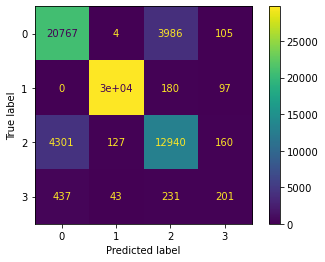

In [14]:
label = ['hospitalized', 'nonhospitalized','recovered', 'deceased']
va_pred = model.predict(va)
ev_va_report = classification_report(va_y, va_pred)
ev_va_accuracy = accuracy_score(va_y, va_pred)
ev_va_matrix = confusion_matrix(va_y, va_pred,labels=label)
print(ev_va_report)
ConfusionMatrixDisplay(ev_va_matrix).plot()

In [ ]:
# # Check if prediction file is valid
# def check_if_file_valid(filename):
#     assert filename.endswith('../results/predictions.txt'), 'Incorrect filename'
#     f = open(filename).read()
#     l = f.split('\n')
#     assert len(l) == 46500, 'Incorrect number of items'
#     assert (len(set(l)) == 4), 'Wrong class labels'
#     return 'The predictions file is valid'
# check_if_file_valid('predictions.txt')

In [ ]:
# # Specifying possible parameters of catboost - Grid Search
# grid = {'learning_rate': [0.2, 0.3, 0.4],
#         'depth': [10, 14],
#         'l2_leaf_reg': [0.0, 0.2],
#         'n_estimators':[100, 200, 400]
#        }

# # Specify catboost parameters
# cat_feature=['sex','source','age_range_ind','age_range']
# text_feature = ['additional_information']

# # Creating required scoring function
# scorer = {
#     'f1_macro' : make_scorer(f1_score, average='macro'),
#     'recall_macro': make_scorer(recall_score , average='macro'),
#     'accuracy': make_scorer(accuracy_score),
#     'recall_d' : make_scorer(recall_score,average=None,labels=['deceased']),
#     'f1_d' : make_scorer(f1_score, average=None, labels=['deceased']),
# }

# # Creating Catboost model
# model = CatBoostClassifier( task_type="GPU",
#                             devices='0:1',
#                             loss_function='MultiClass',
#                             auto_class_weights = 'SqrtBalanced',
#                             cat_features = cat_feature,
#                             text_features = text_feature)

# clf_grid = GridSearchCV(estimator=model, param_grid=grid, scoring=scorer, cv= 5, refit="f1_d", n_jobs=1, verbose=1)
# clf = clf_grid.fit(tr, tr_y)